In [5]:
### Reloads modules properly
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [6]:
import os

os.sys.path.append("../")

In [163]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mplhep as hep
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.interpolate import interp1d

hep.style.use("CMS")

# FastHisto Failures

Explore where FastHisto Fails and how? 

In [8]:
from primaryvertexingtools import PrimaryVertexing

In [9]:
from primaryvertexingtools import PerformanceMetrics

In [10]:
from primaryvertexingtools import create_pv_truth_labels, remove_nans

In [11]:
trk = pd.read_pickle("/media/lucas/QS/l1_nnt/trk_25k.pkl")

In [12]:
mc = pd.read_pickle("/media/lucas/QS/l1_nnt/mc_25k.pkl")

In [13]:
trk = create_pv_truth_labels(trk)

In [14]:
trk = remove_nans(trk)

In [15]:
fh_bins = np.linspace(-15, 15, 256)

In [16]:
mydict = {"track_data": trk, "truth_data": mc, "test_run": False, "fh_bins": fh_bins}

In [17]:
PV = PrimaryVertexing(mydict)

Initialized Primary Vertexing setup


In [19]:
PV.run_fh()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25000/25000 [00:06<00:00, 4076.08it/s]


Ran Fast Histo


In [20]:
PV.run_dbscan()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25000/25000 [01:14<00:00, 337.39it/s]


Ran DBSCAN with eps: 0.08, minPts: 2


In [21]:
PM = PerformanceMetrics(PV)

0.11908531
positive bias 0.03469515
negative bias -0.035159588


In [28]:
res = pd.DataFrame({"res": np.abs(PM.z0_gen - PM.z0_reco_fh_cor)})

In [29]:
res["pv_reco"] = res < 0.1

In [30]:
res

,res,pv_reco
0,0.072567,True
1,0.034672,True
2,0.085902,True
3,0.069936,True
4,0.063947,True
...,...,...
24995,0.032974,True
24996,0.062440,True
24997,0.027930,True
24998,0.114216,False


In [184]:
res["above_1"] = res["res"] > 1
res["above_0_5"] = res["res"] > 0.5
res["above_0_25"] = res["res"] > 0.25
res["above_0_15"] = res["res"] > 0.15
res["above_0_10"] = res["res"] > 0.10

In [122]:
res_fail = res.loc[res["pv_reco"] == False].copy()

In [93]:
res_fail

,res,pv_reco,above_1,above_0_5,above_0_25
12,1.014115,False,True,True,True
35,0.145083,False,False,False,False
38,4.538876,False,True,True,True
40,0.156243,False,False,False,False
53,0.198920,False,False,False,False
...,...,...,...,...,...
24981,0.120938,False,False,False,False
24988,0.104042,False,False,False,False
24989,4.273881,False,True,True,True
24994,9.403546,False,True,True,True


In [171]:
total_events = res.shape[0]

In [173]:
h_res, be = np.histogram(res.res, bins=[0, 0.1, 0.15, 0.25, 0.5, 1.0, 30])

In [178]:
h_res

array([18573,  3014,  1685,   582,   182,   964])

In [179]:
perc = 100 * h_res / total_events

In [180]:
perc

array([74.292, 12.056,  6.74 ,  2.328,  0.728,  3.856])

In [183]:
results = pd.DataFrame(
    {
        "percentage": perc,
        "boundaries": [
            "0<res<0.1",
            "0.1<res<0.15",
            "0.15<res<0.25",
            "0.25<res<0.5",
            "0.5<res<1",
            "1<res",
        ],
    }
)
results

,percentage,boundaries
0,74.292,0<res<0.1
1,12.056,0.1<res<0.15
2,6.740,0.15<res<0.25
3,2.328,0.25<res<0.5
4,0.728,0.5<res<1
5,3.856,1<res


In [36]:
def z0_reco_fh_bin(bin_edges: np.array, max_index: int) -> float:
    "Function returns the reconstructed z0 value for fast histo based on the maximum bin"
    half_bin_width = 0.5 * (bin_edges[1] - bin_edges[0])
    lowest_bin = bin_edges[0]
    highest_bin = bin_edges[-1]
    nbins = bin_edges.shape[0]

    z0 = lowest_bin + (highest_bin - lowest_bin) * (max_index / nbins) + half_bin_width

    return z0

In [166]:
def inv_ecdf(h, edges):
    x = 0.5 * (edges[1:] + edges[:-1])
    cf = np.zeros(len(x))
    count = 0

    for i, _ in enumerate(cf):
        count = count + h[i]
        cf[i] = count

    cp = 100 * cf / sum(h)

    d = interp1d(cp, x)

    return d

In [45]:
mc.query("entry<2")["pv_MC"].values

array([ 5.055163 , -3.6086612], dtype=float32)

In [128]:
a = trk.query(f"entry==0")["trk_z0"].describe([0.05, 0.95])

In [231]:
def plot_fast_histo(
    df: pd.DataFrame,
    truth: pd.DataFrame,
    res: pd.DataFrame,
    event_number: int,
    xlim="auto",
):
    plt.figure(figsize=(16, 8))
    _df = df.query(f"entry=={event_number}")

    _truth = truth.query(f"entry=={event_number}")["pv_MC"].values

    be = np.linspace(-15, 15, 256)

    h, be = np.histogram(_df.trk_z0, bins=be, weights=_df.trk_pt)
    h = np.convolve(h, [1, 1, 1], mode="same")
    hep.histplot(h, be, label="reco")

    max_index = np.argmax(h)
    if xlim == "auto":
        d = inv_ecdf(h, be)
        xmin = d(5)
        xmax = d(95)

        xlim = [xmin, xmax]

    z0_pv = z0_reco_fh_bin(be, max_index)
    pv_res = res.iloc[i][0]
    pv_res = np.round(pv_res, 3)
    plt.axvline(z0_pv, label="reco z0 pv", color="crimson", lw=2, ls="--")
    plt.axvline(_truth, label="truth z0 pv", color="green", lw=2, ls="--")
    plt.legend(fontsize=14)
    plt.xlim(xlim)
    plt.xlabel("$z_{0}$", fontsize=14)
    plt.tick_params(axis="both", which="major", labelsize=14)
    plt.title(
        f"Fast Histo reco event {event_number}, resolution " + str(round(pv_res, 3)),
        fontsize=16,
    )

In [232]:
np.round(res.iloc[61][0], 3)

0.279

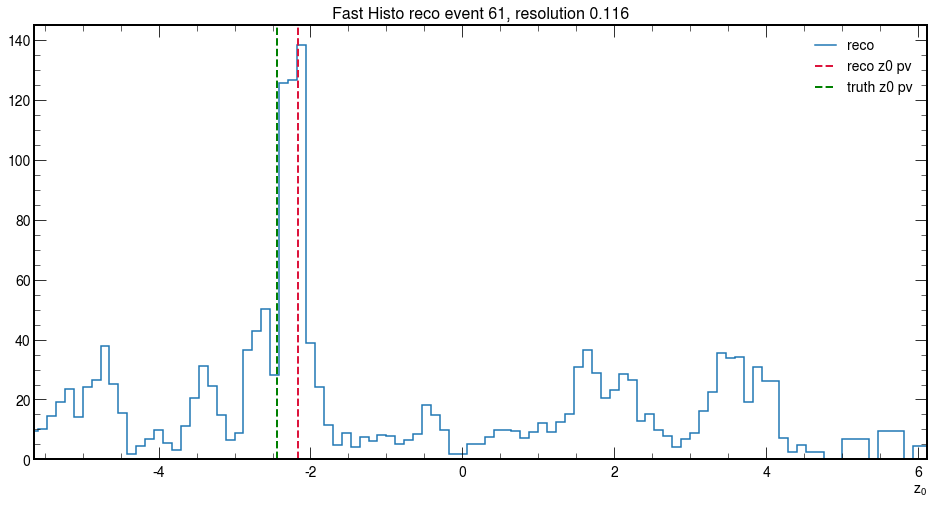

In [233]:
plot_fast_histo(PM.trk, mc, res, 61, xlim="auto")

In [234]:
res_fail.loc[res_fail["above_1"] == True]

,res,pv_reco,above_1,above_0_5,above_0_25,above_0_15
12,1.014115,False,True,True,True,True
38,4.538876,False,True,True,True,True
57,7.769027,False,True,True,True,True
73,10.395434,False,True,True,True,True
78,3.911520,False,True,True,True,True
...,...,...,...,...,...,...
24905,18.522461,False,True,True,True,True
24942,13.357032,False,True,True,True,True
24944,2.354434,False,True,True,True,True
24989,4.273881,False,True,True,True,True


In [101]:
import random

In [104]:
random.seed(1337)

# FAST HISTO EVENTS WITH RESOLUTION 0.1 < RES < 0.15

In [228]:
events_to_check_b1 = random.sample(
    list(res_fail.loc[(res_fail["res"] > 0.1) & (res_fail["res"] < 0.15)].index), 20
)

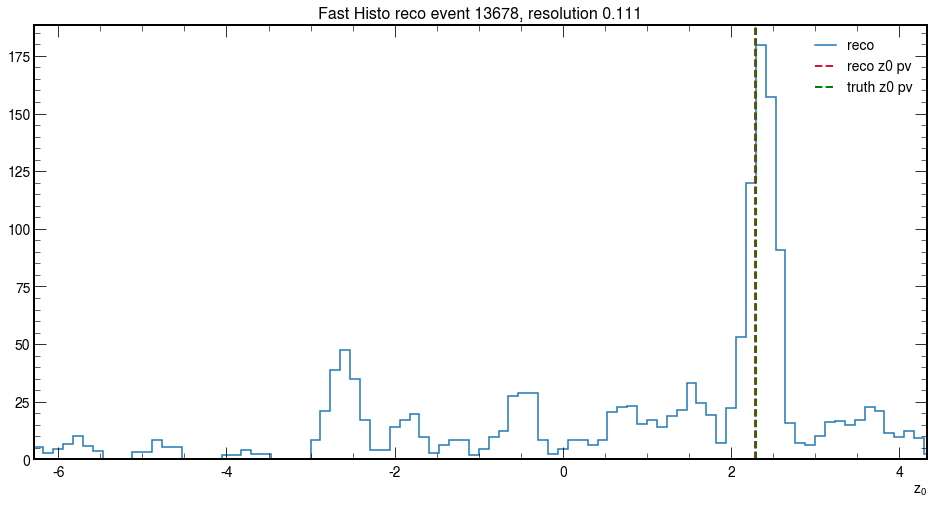

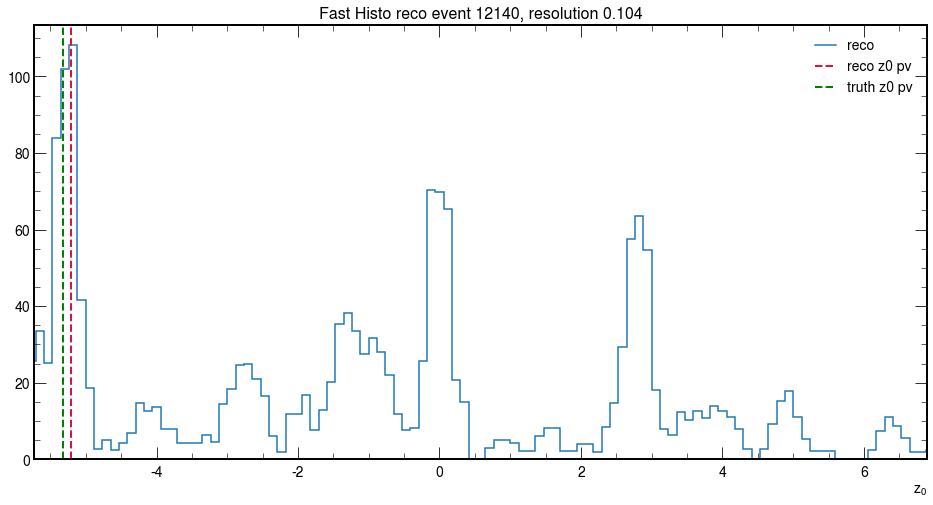

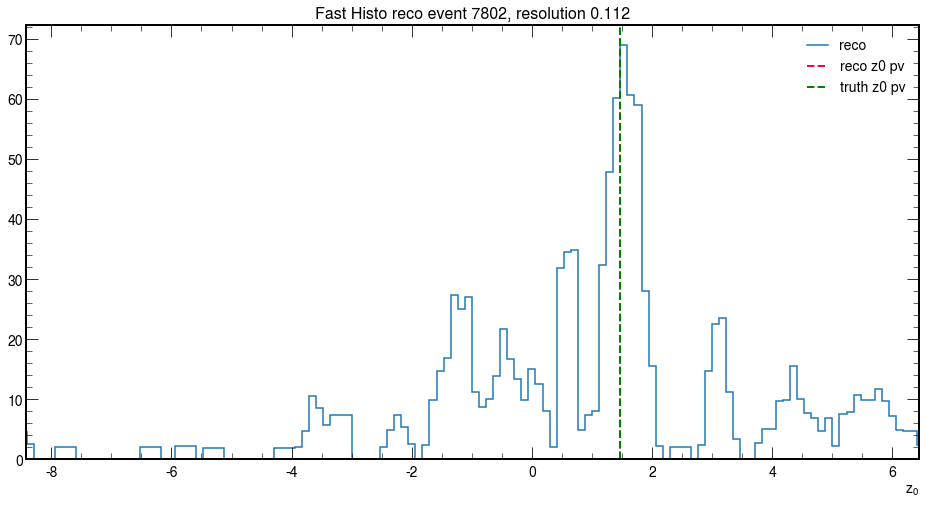

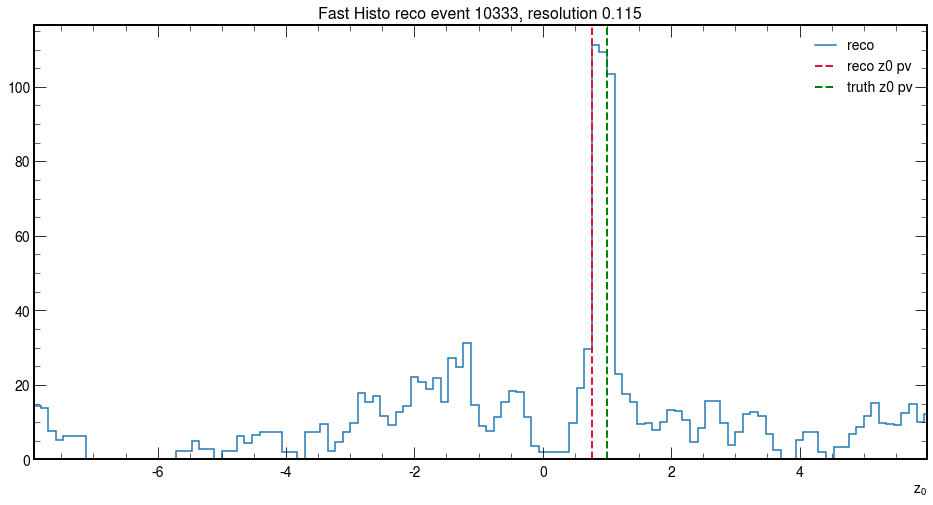

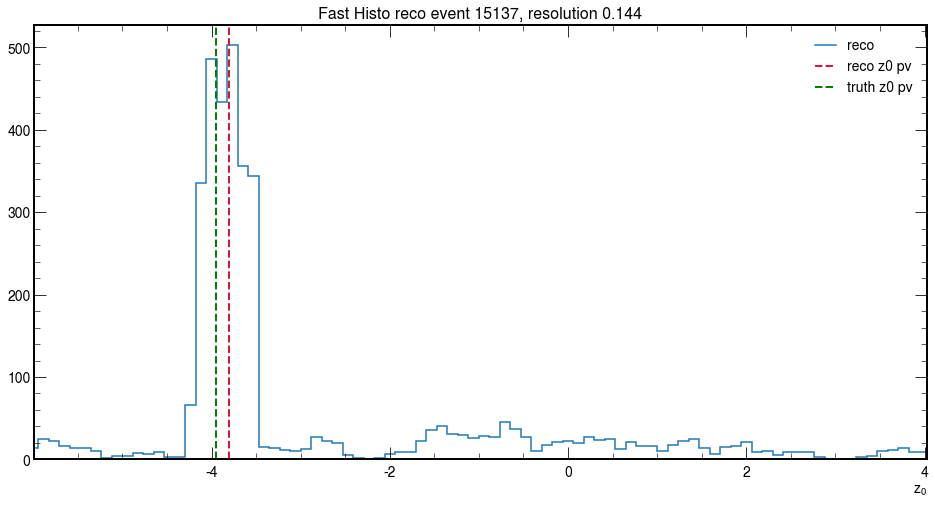

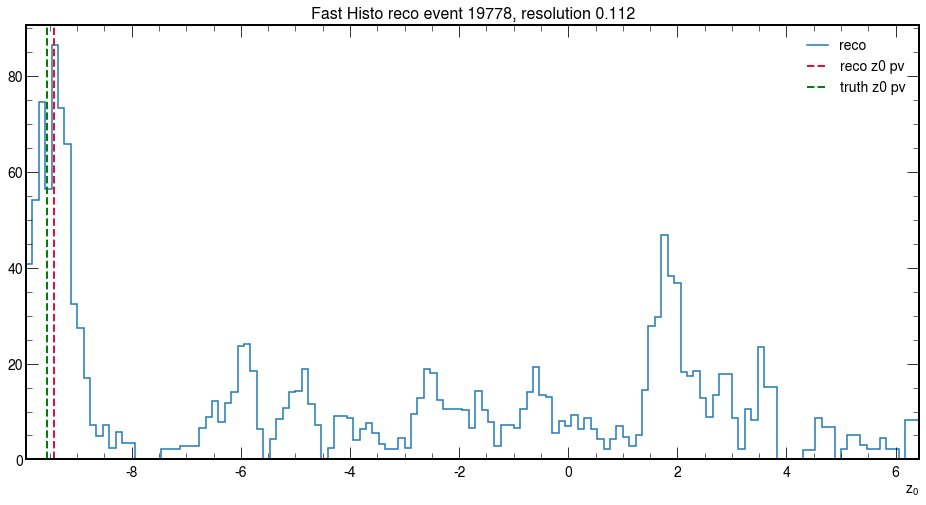

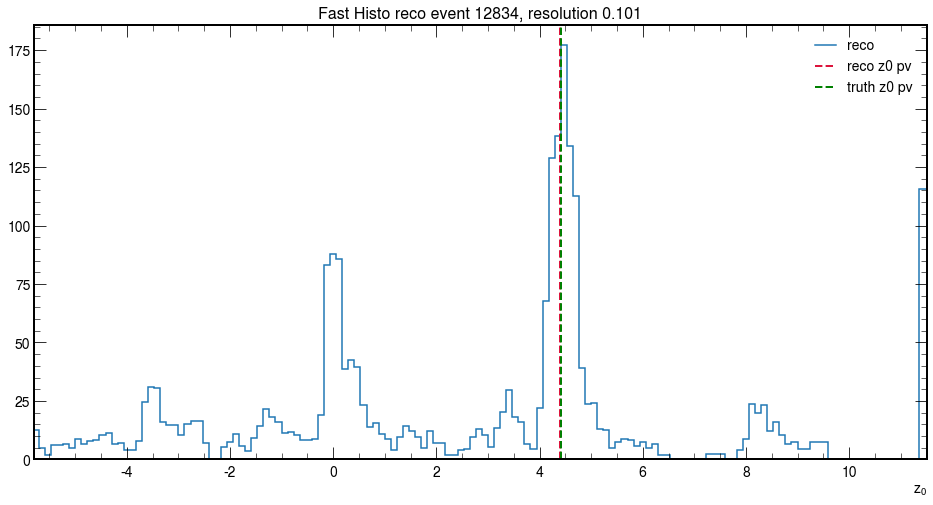

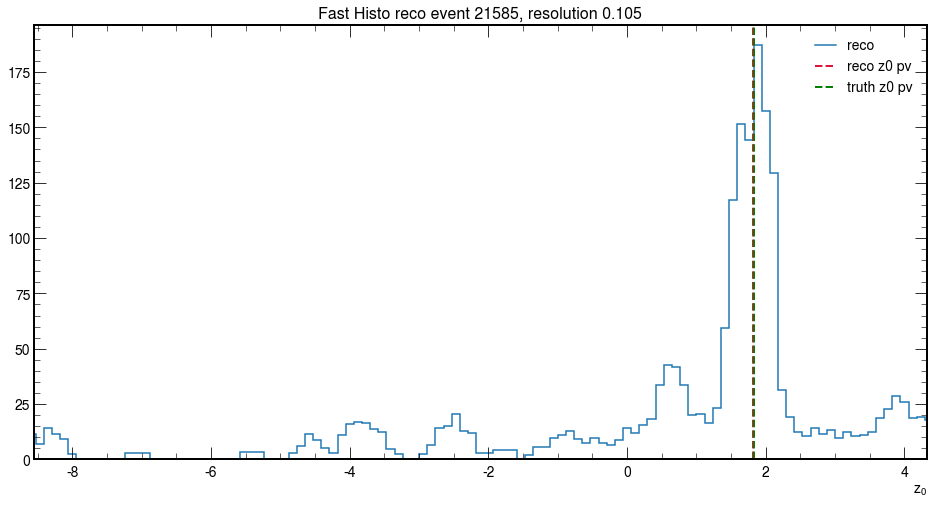

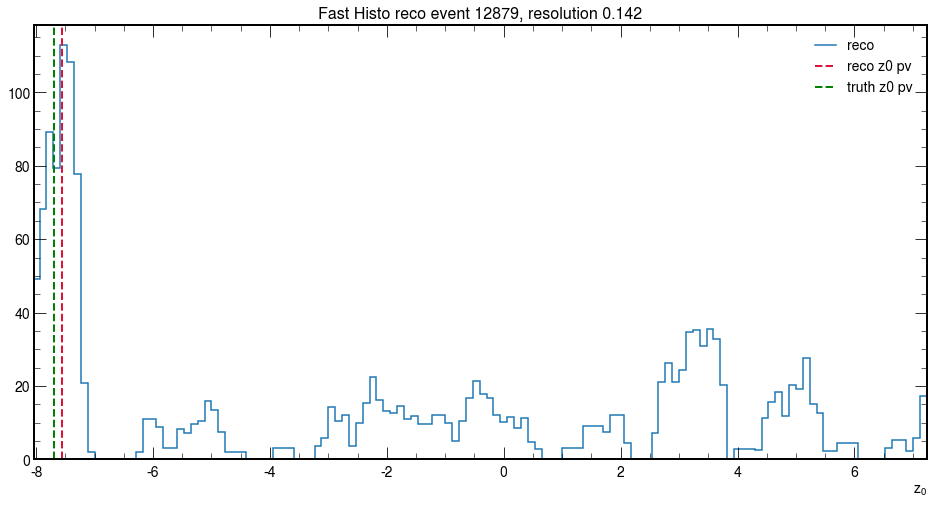

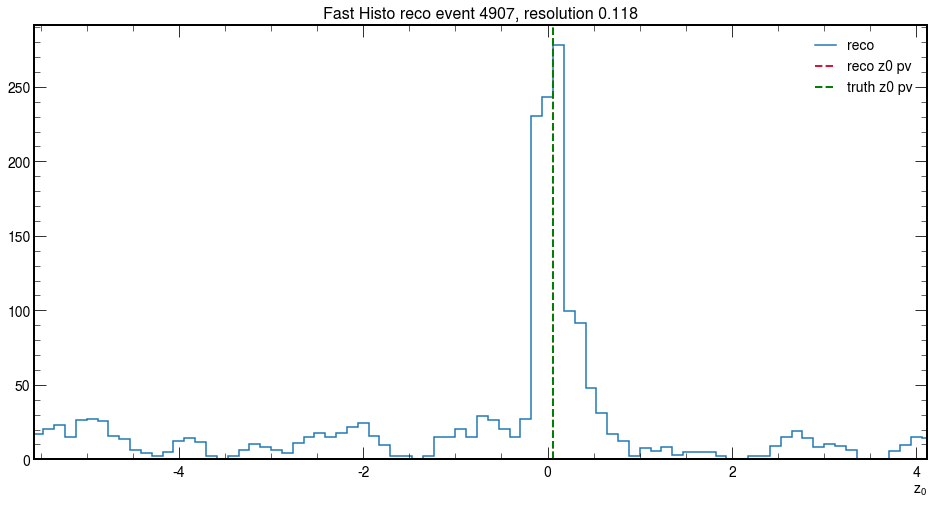

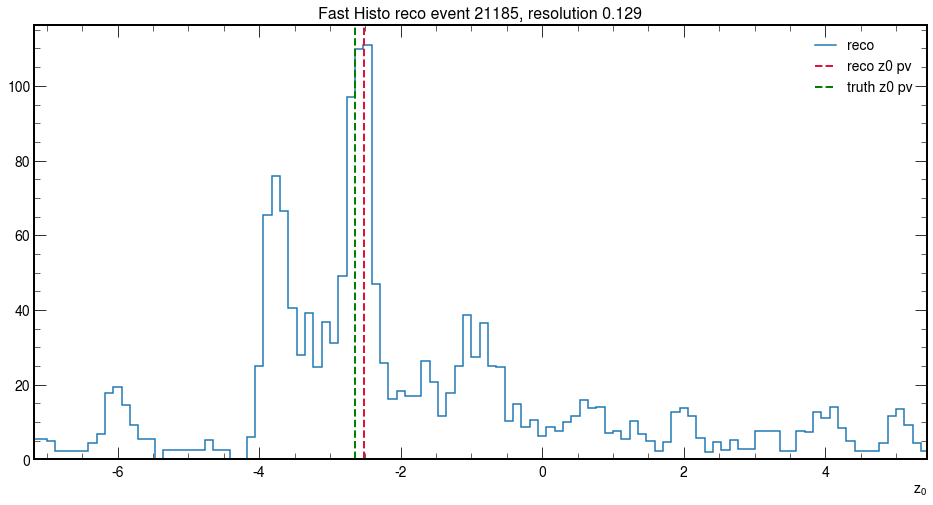

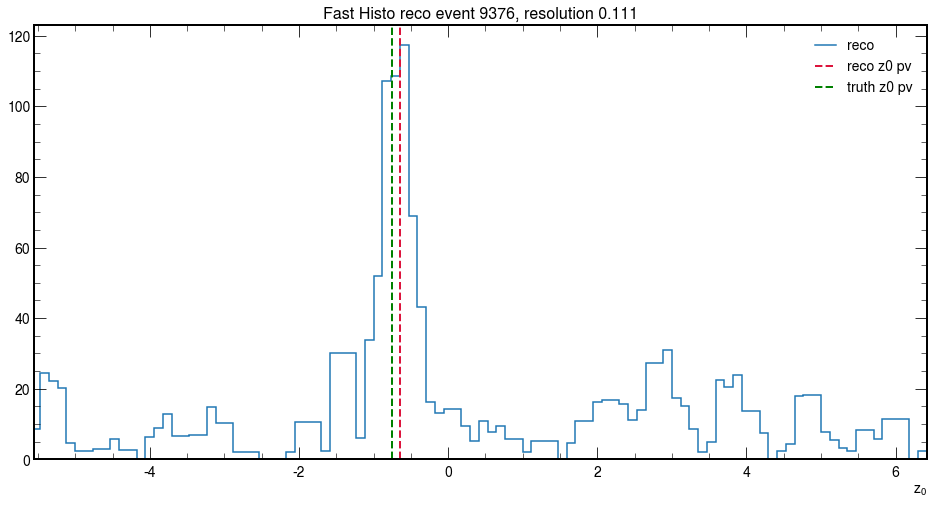

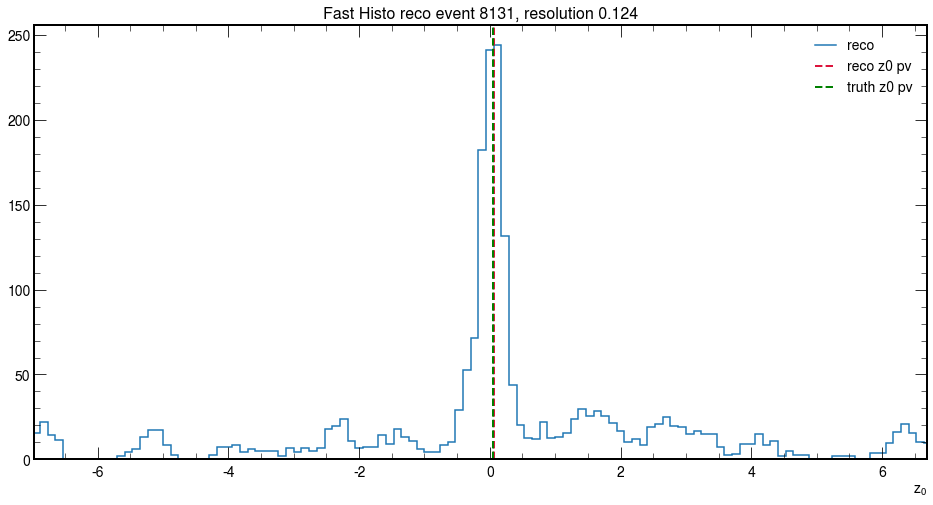

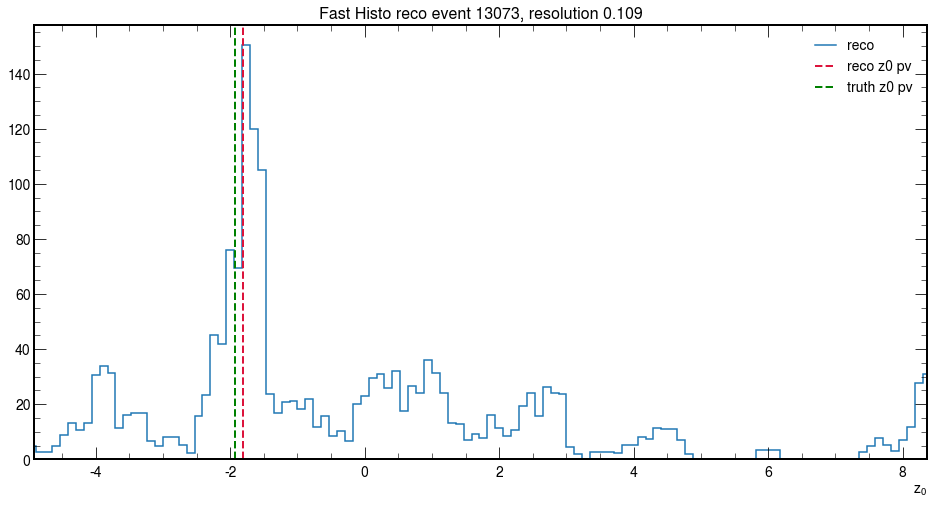

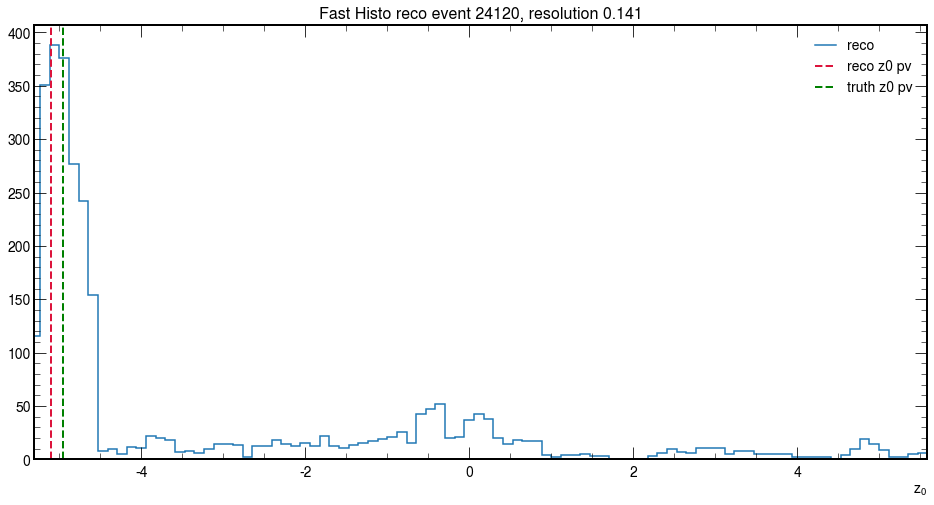

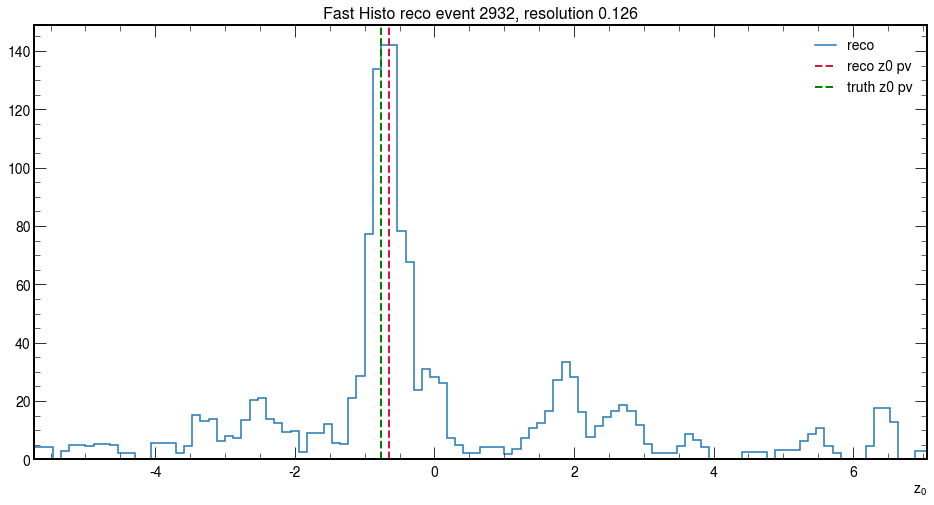

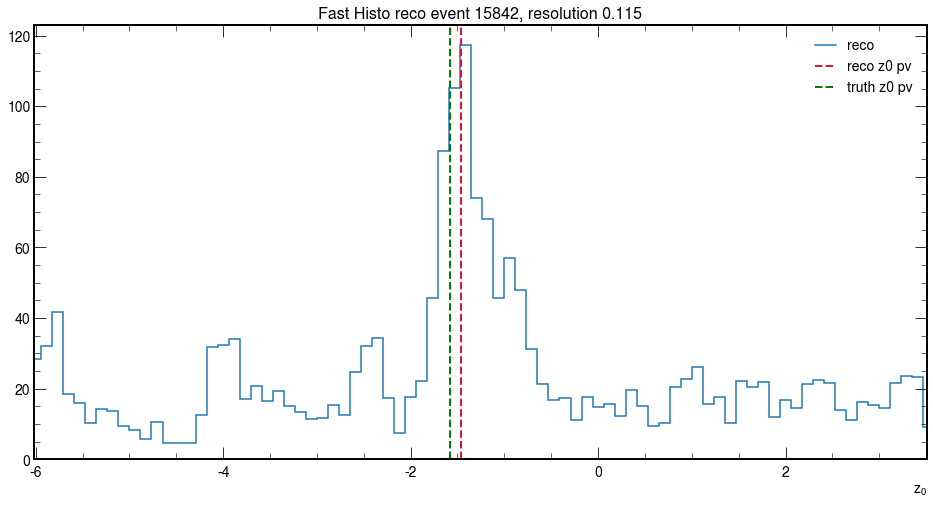

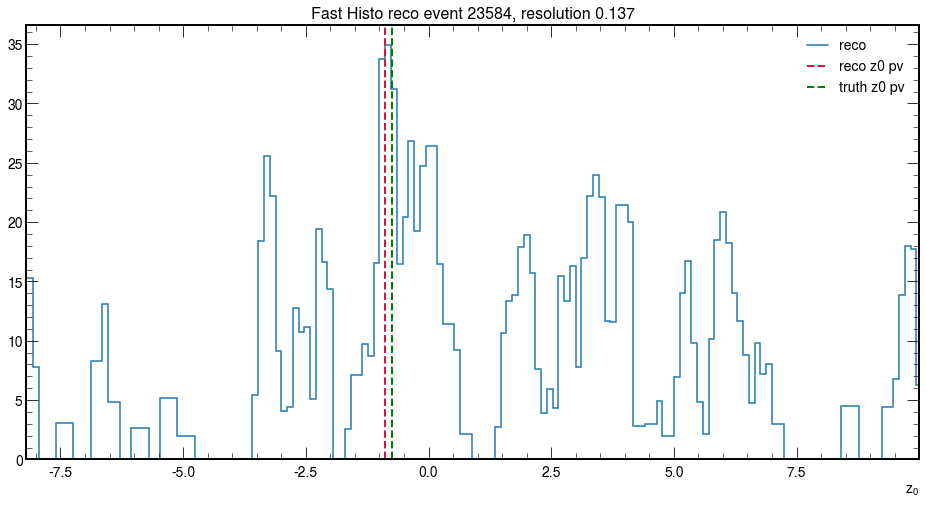

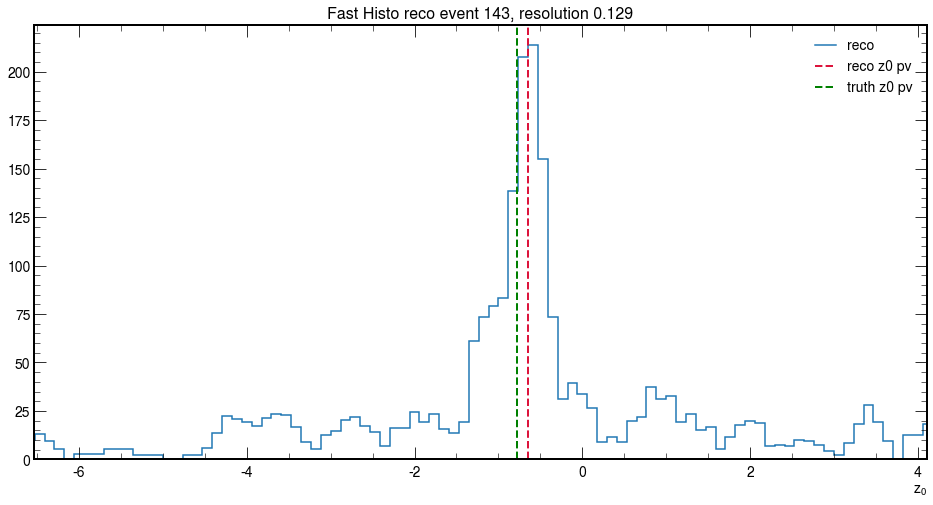

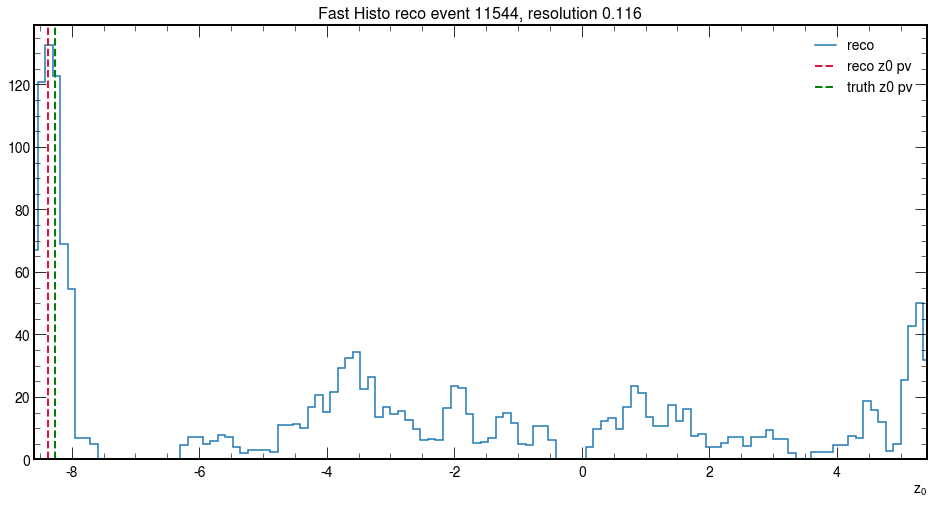

In [235]:
for i in events_to_check_b1:
    plot_fast_histo(PM.trk, mc, res, i, xlim="auto")

# FAST HISTO EVENTS WITH RESOLUTION 0.15 < RES < 0.25

In [188]:
events_to_check_b2 = random.sample(
    list(res_fail.loc[(res_fail["res"] > 0.15) & (res_fail["res"] < 0.25)].index), 20
)

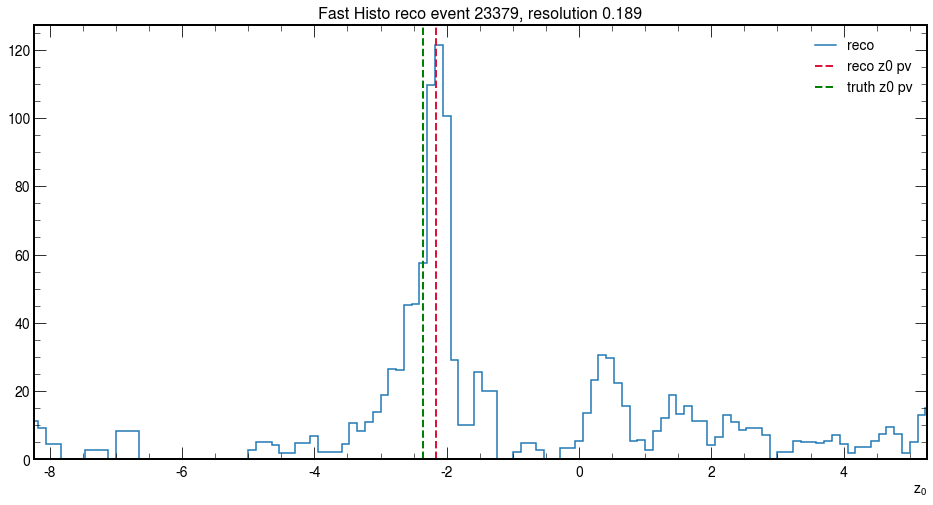

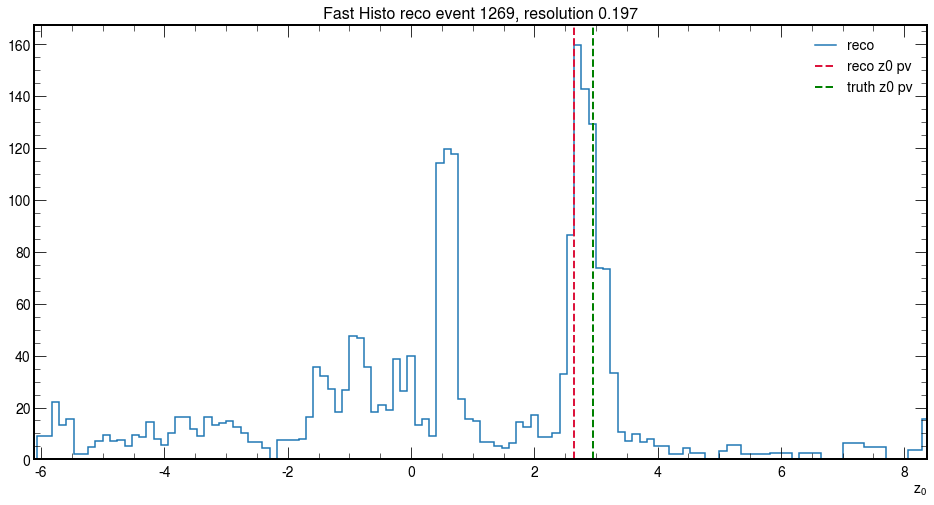

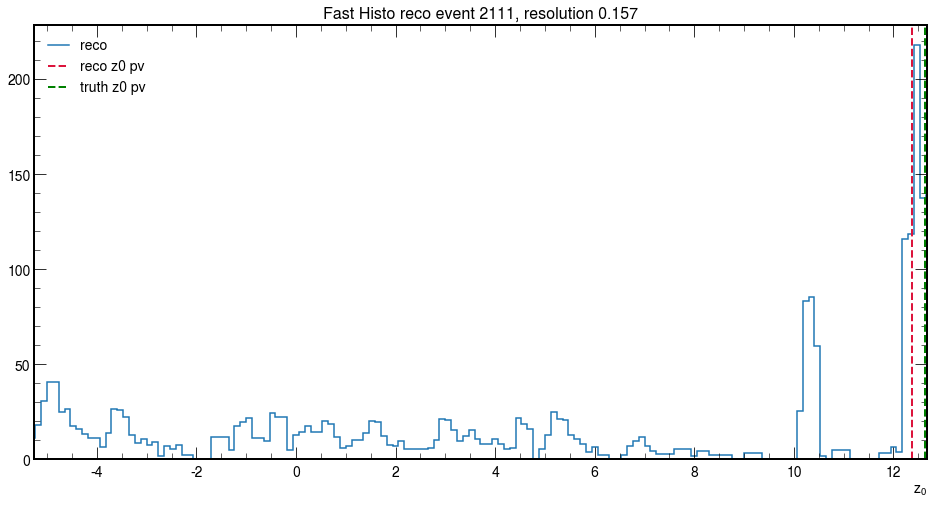

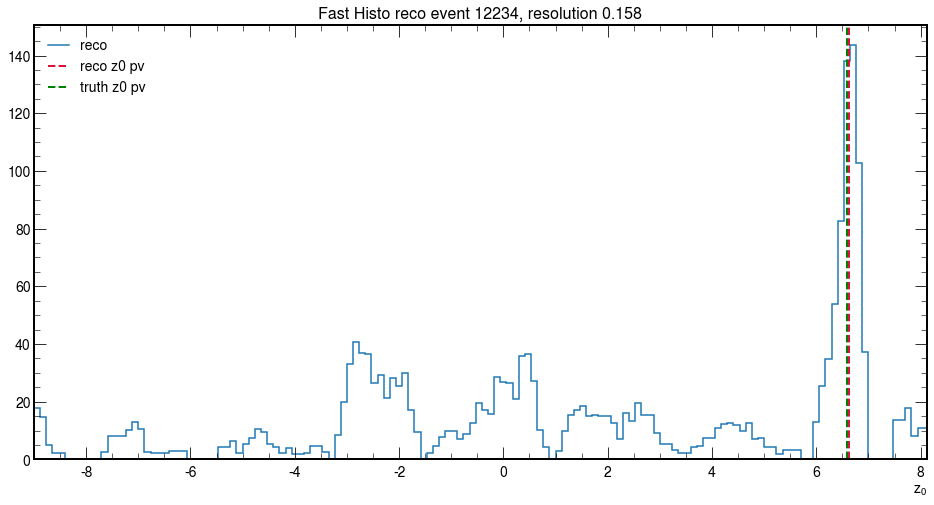

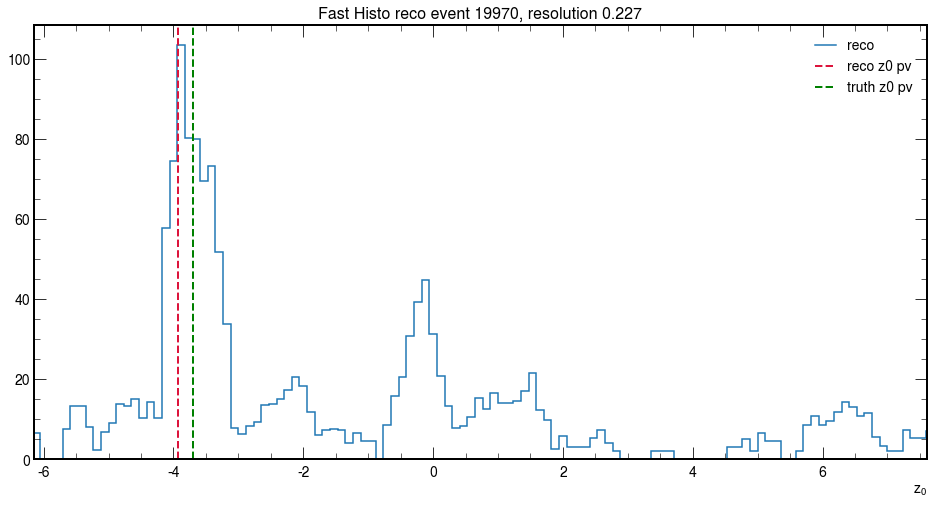

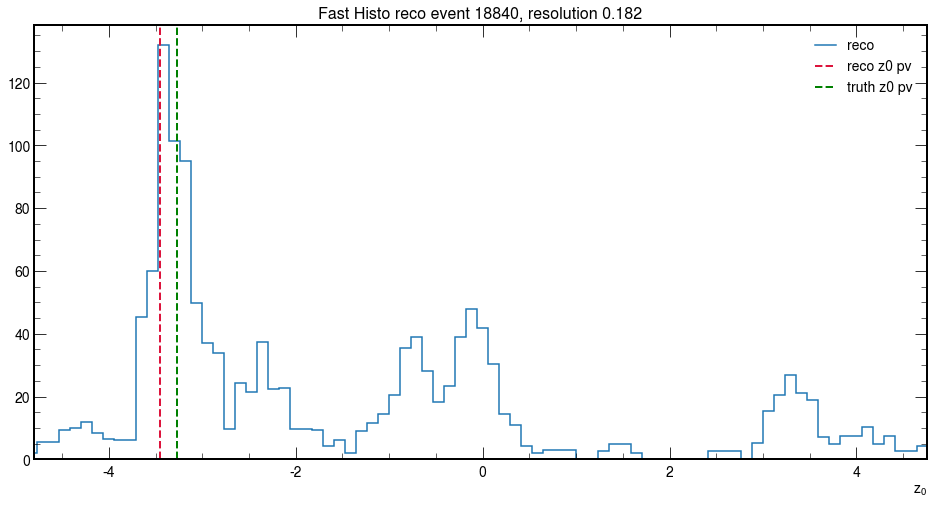

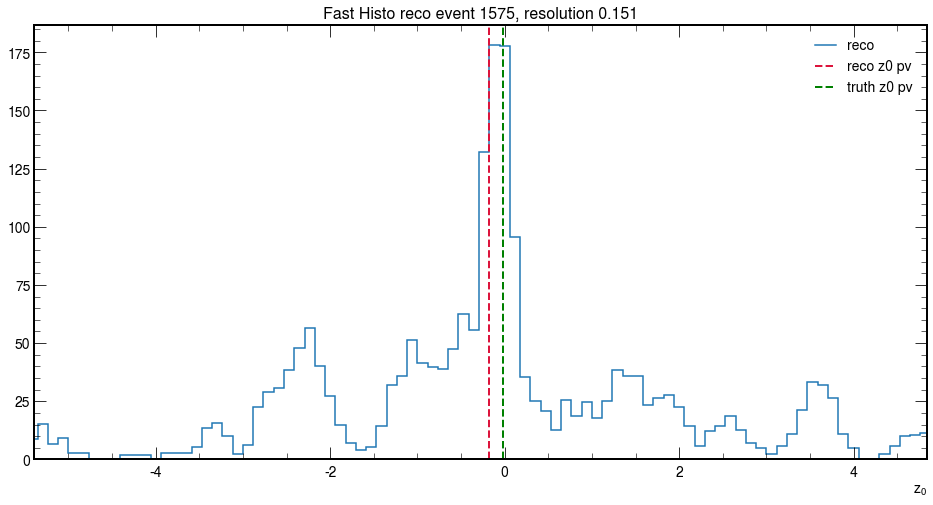

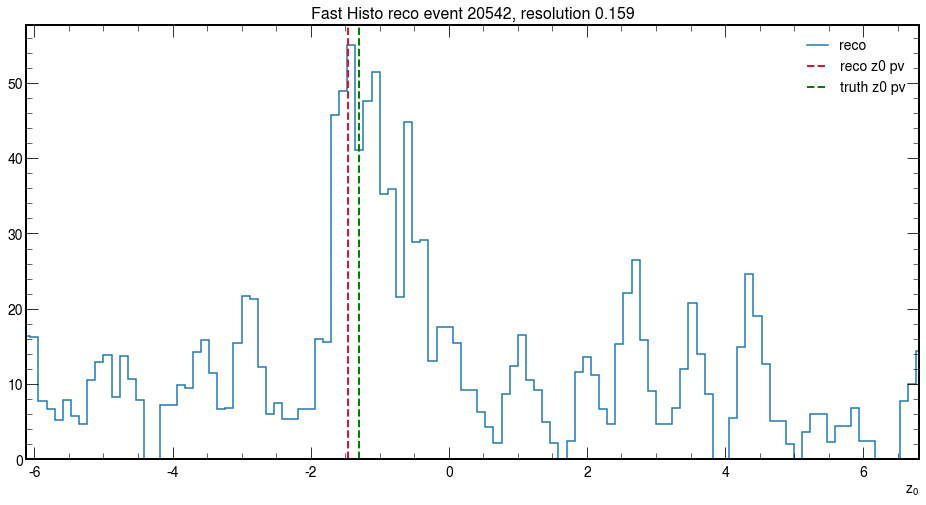

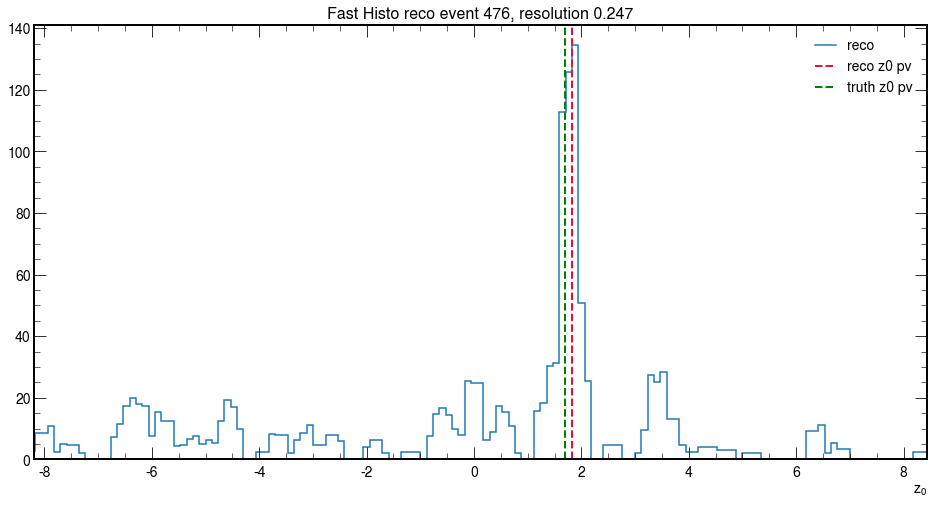

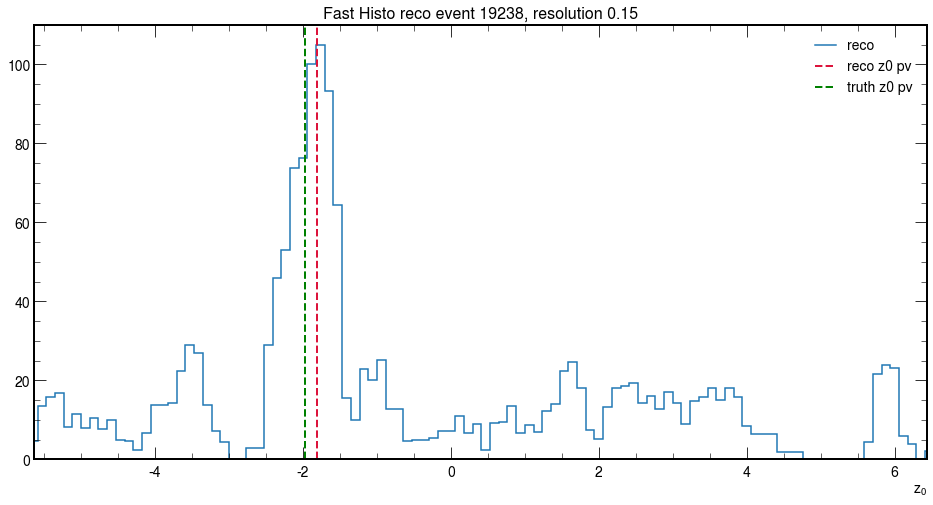

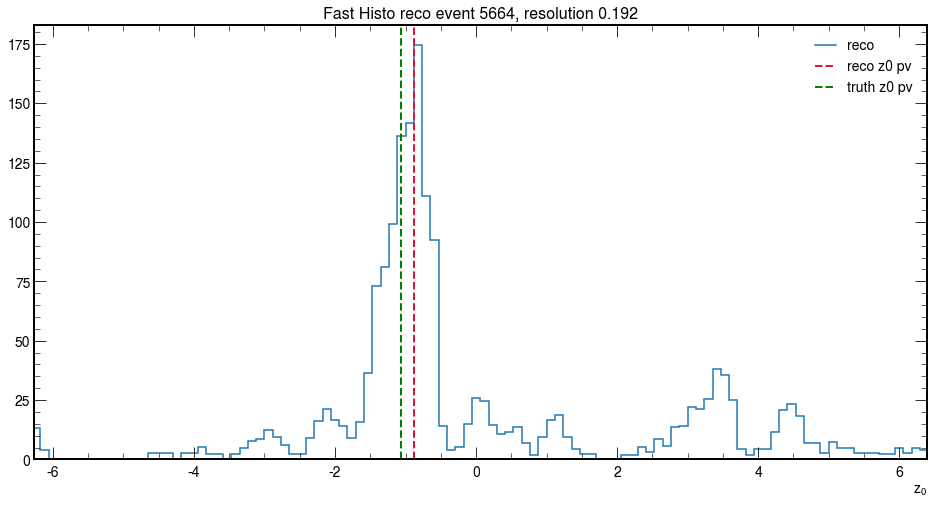

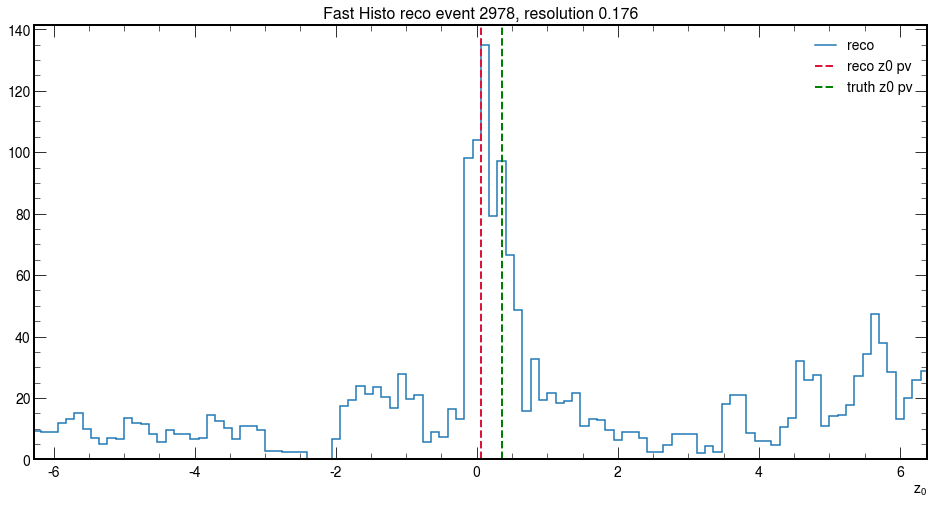

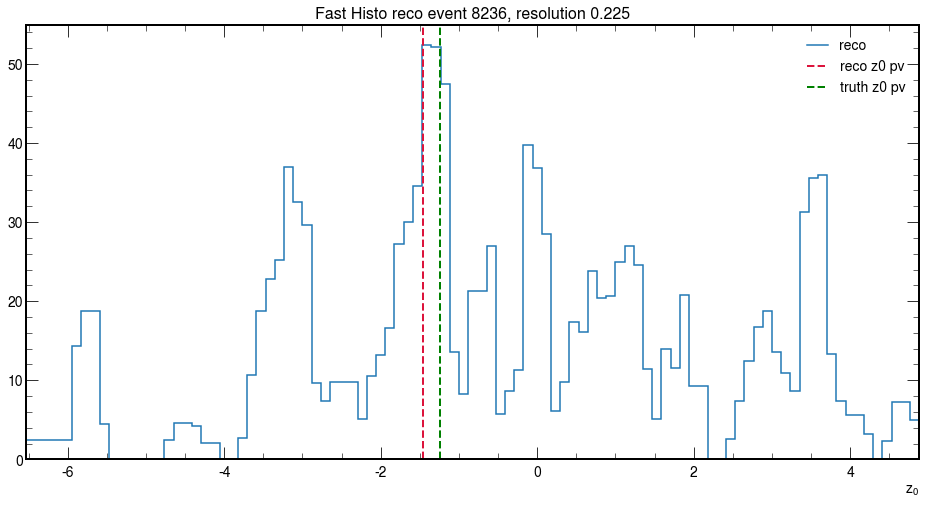

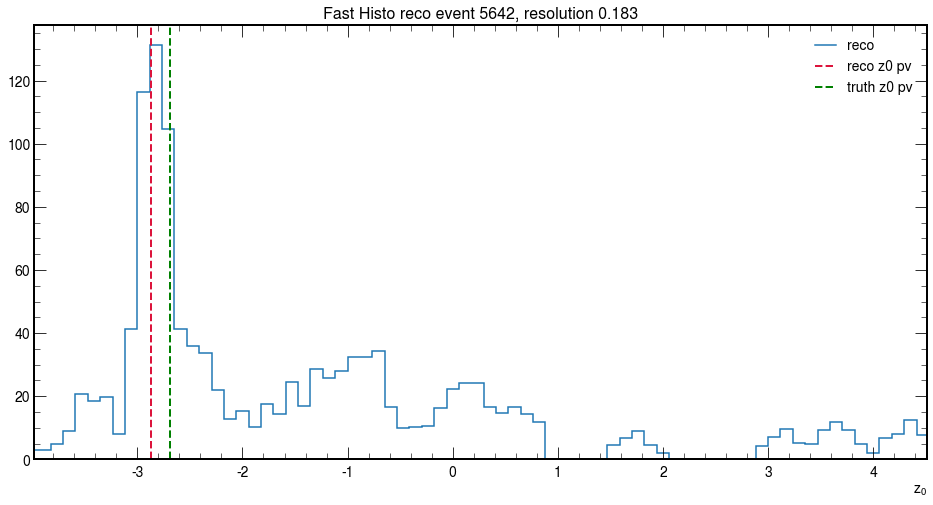

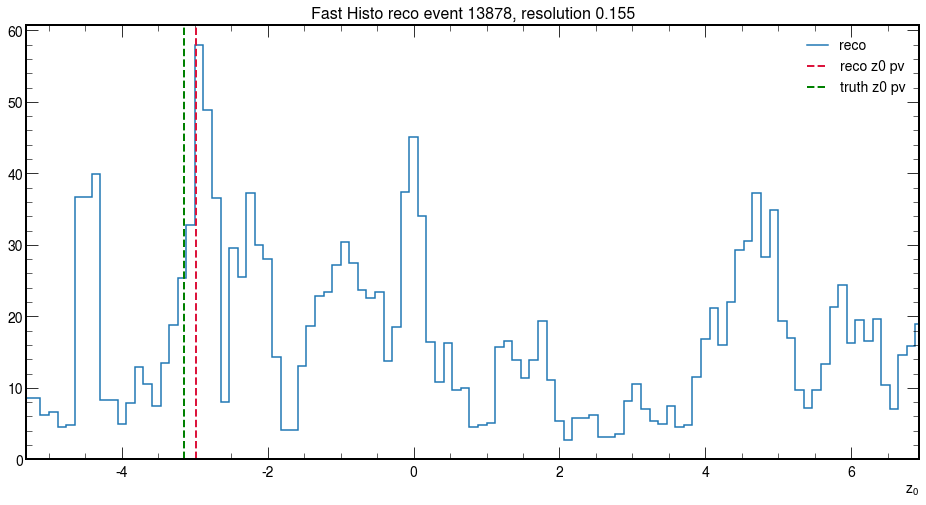

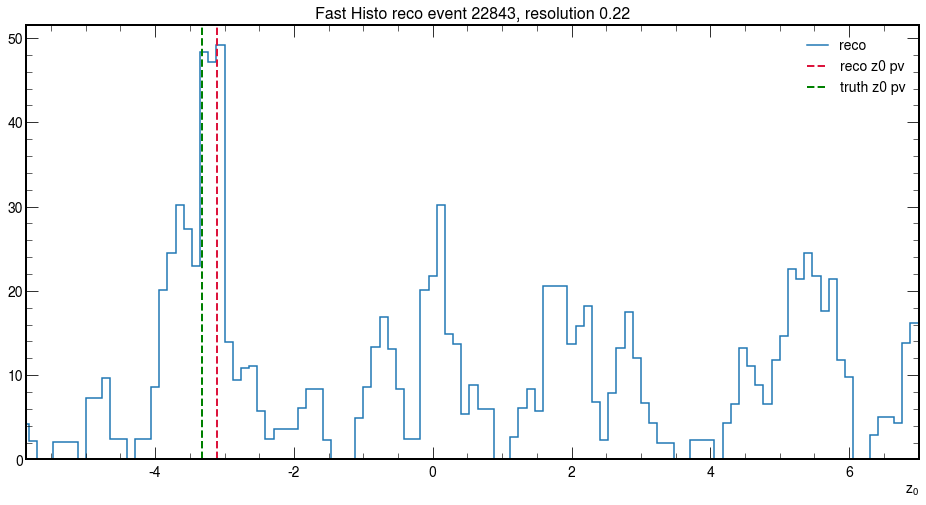

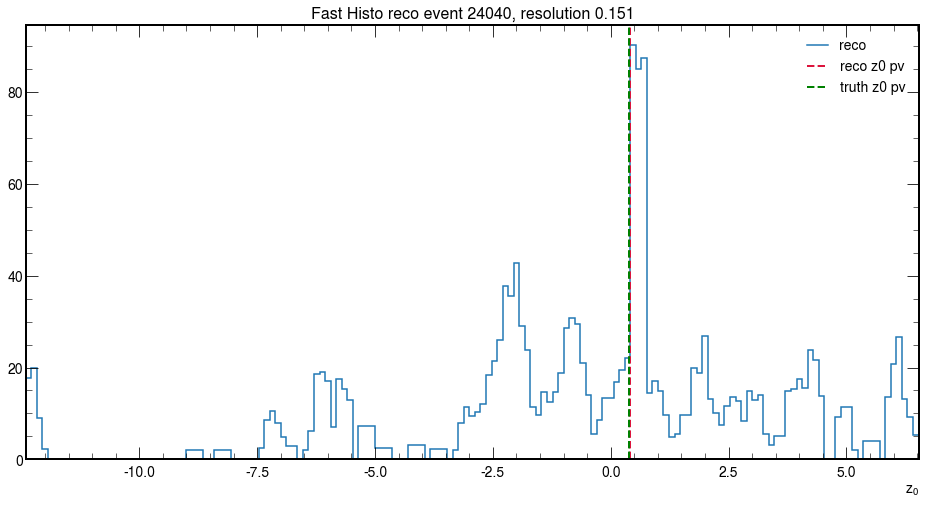

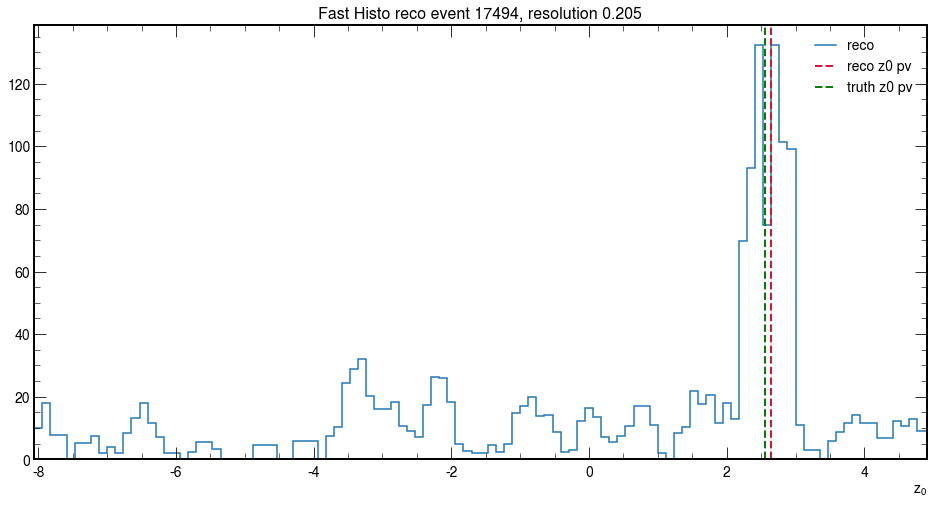

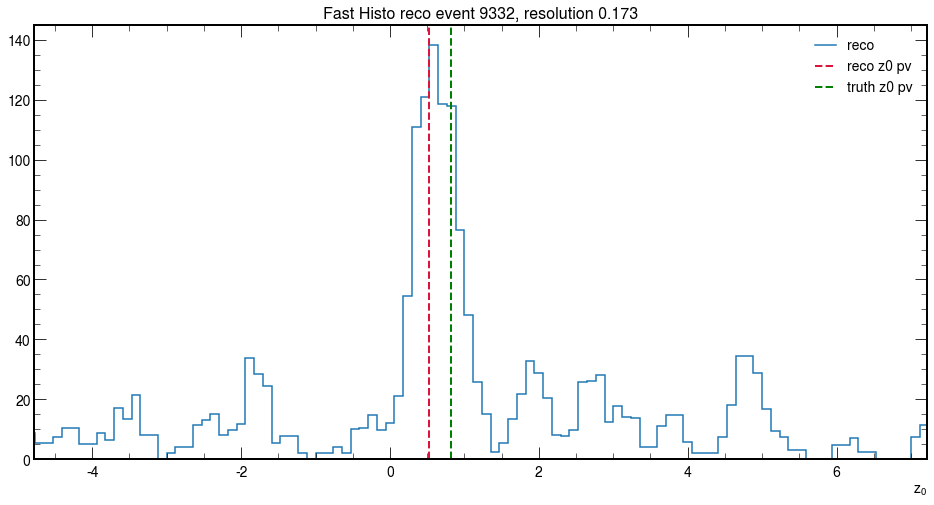

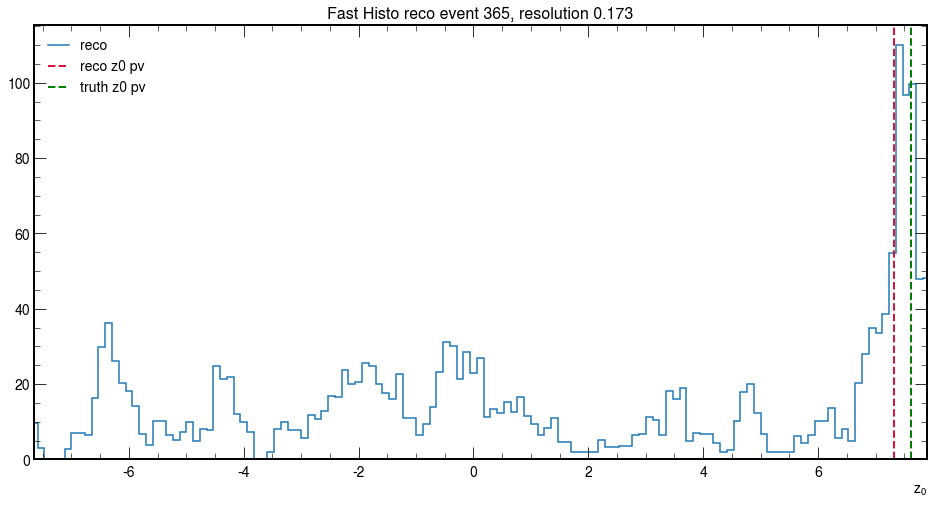

In [236]:
for i in events_to_check_b2:
    plot_fast_histo(PM.trk, mc, res, i, xlim="auto")

# FAST HISTO EVENTS WITH RESOLUTION 0.25 < RES < 0.5

In [189]:
events_to_check_b3 = random.sample(
    list(res_fail.loc[(res_fail["res"] > 0.25) & (res_fail["res"] < 0.50)].index), 20
)

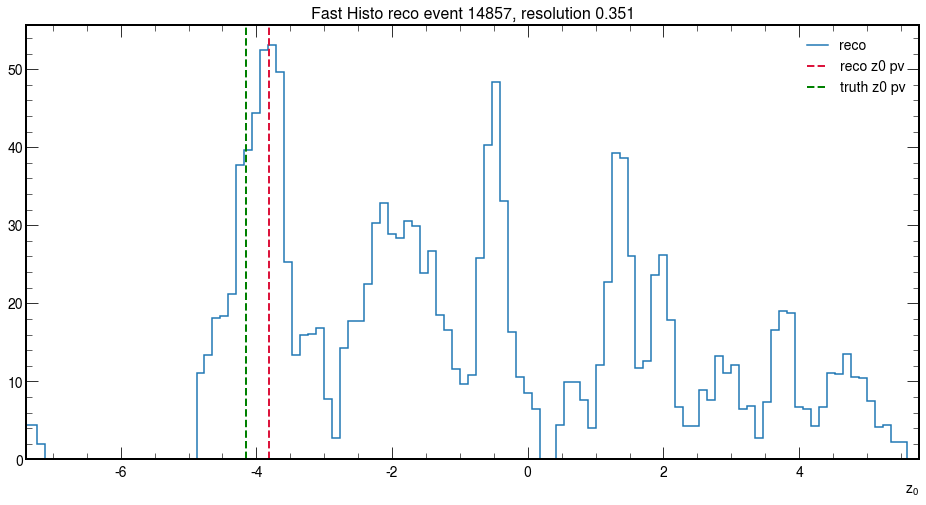

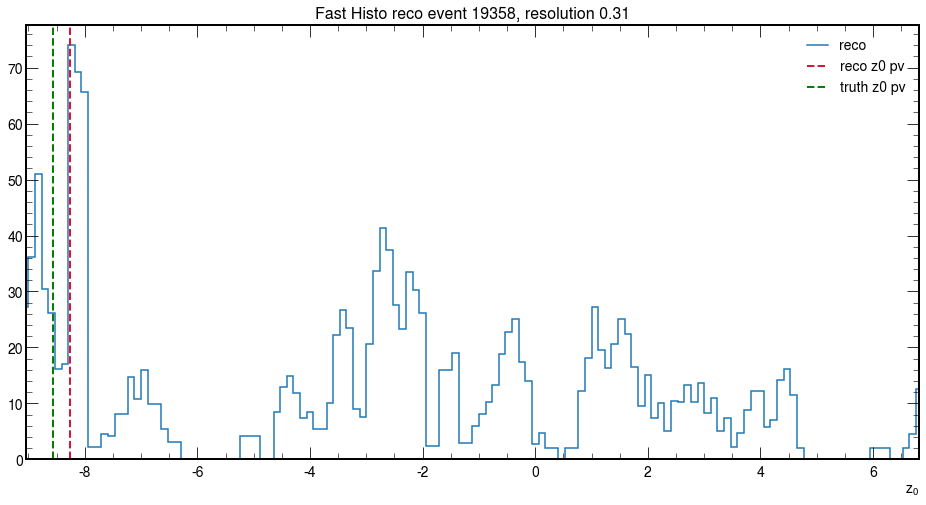

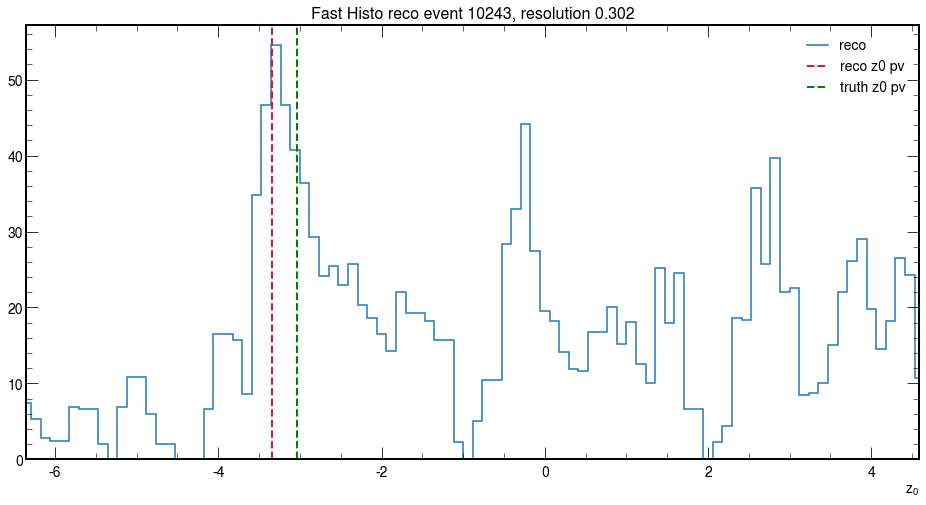

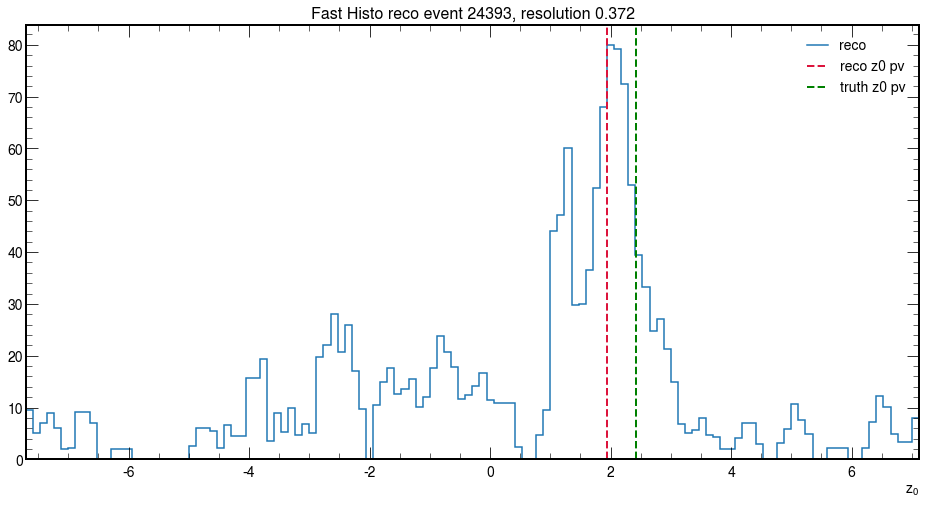

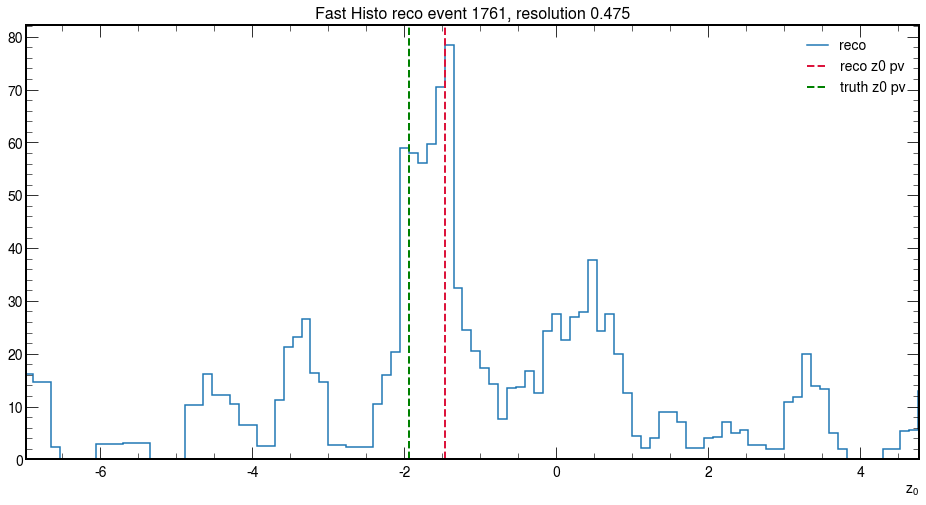

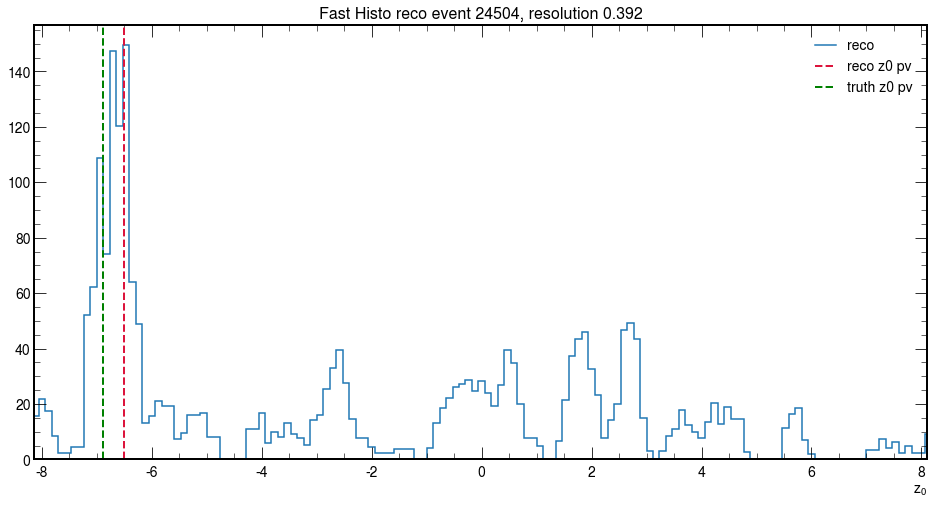

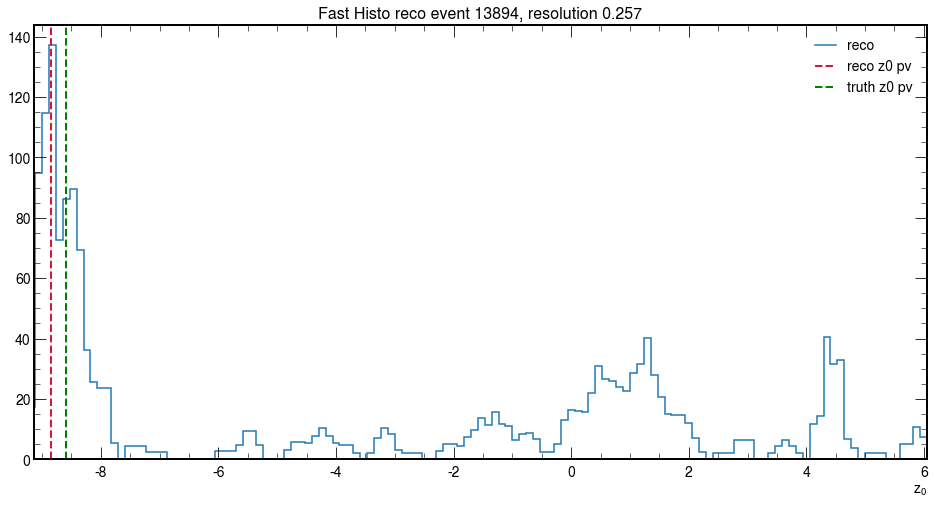

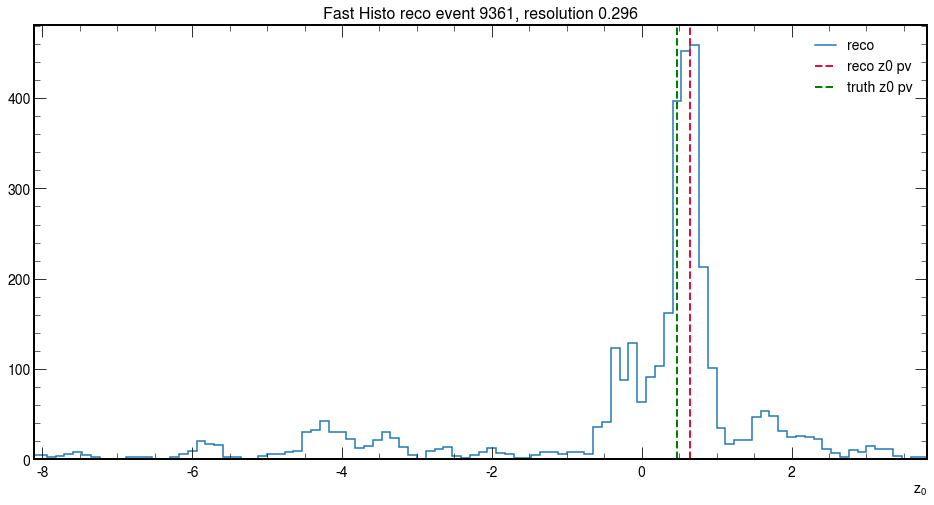

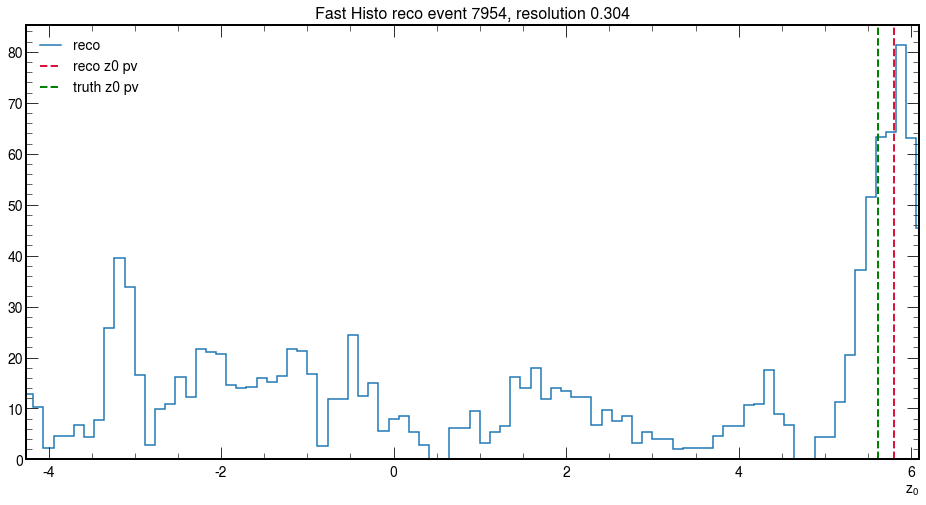

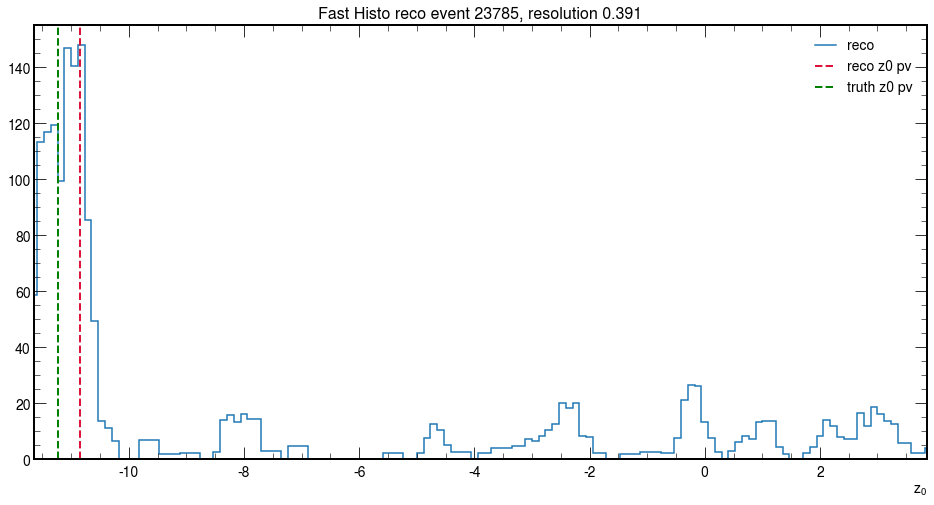

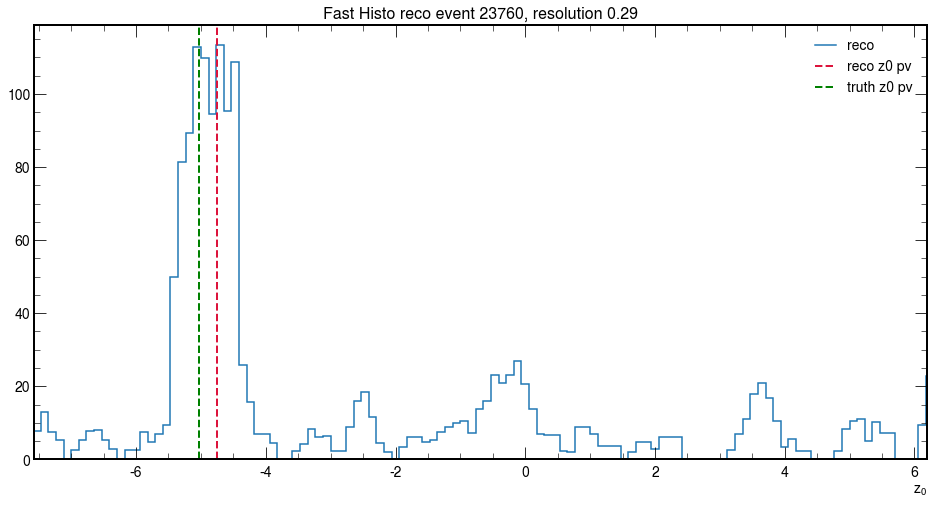

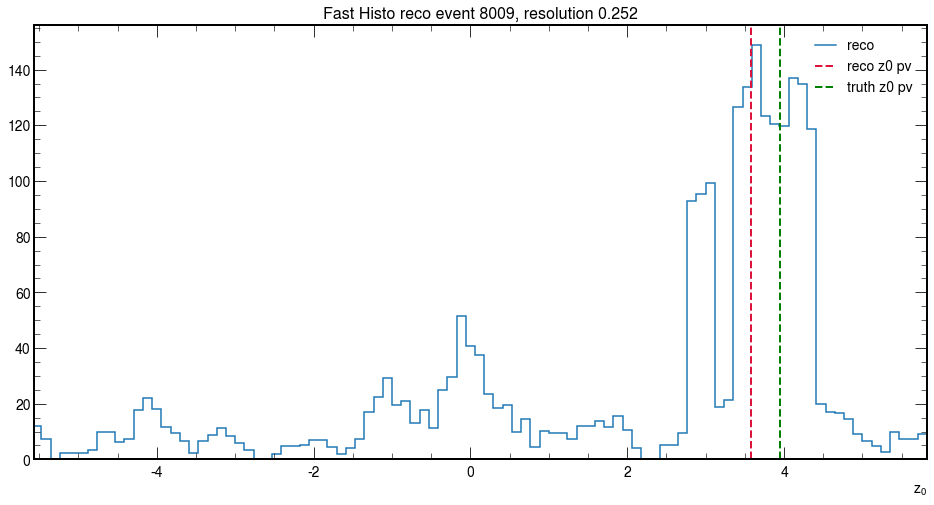

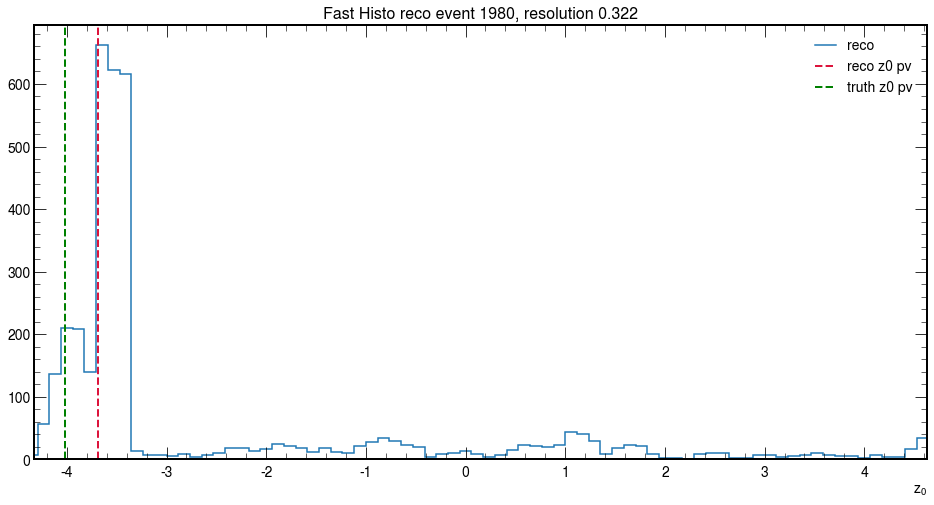

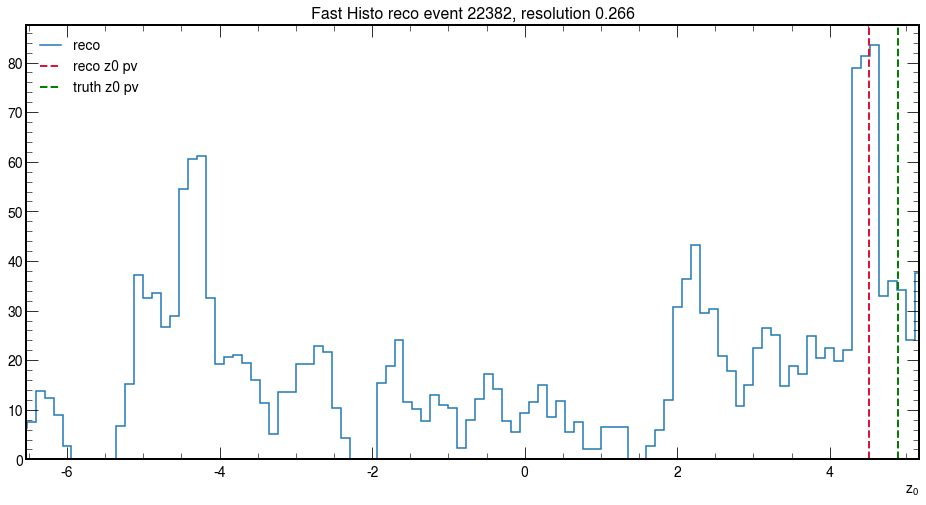

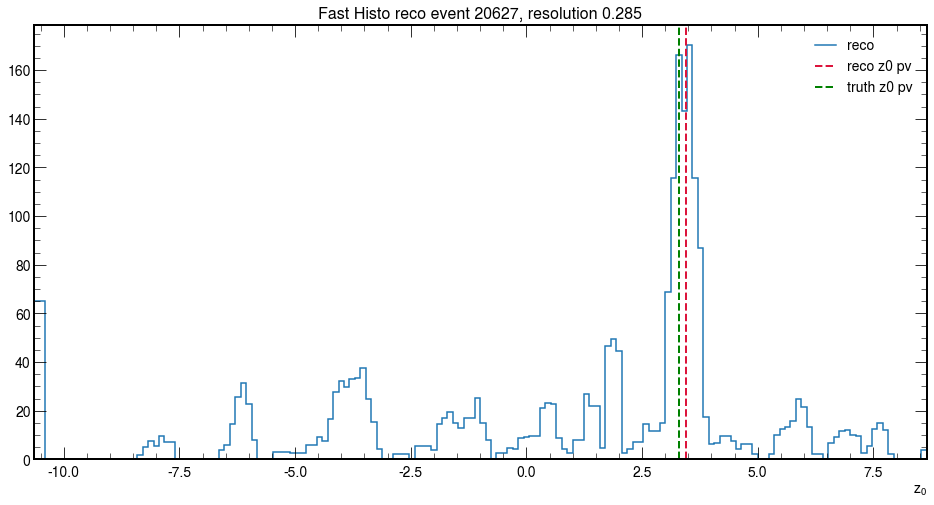

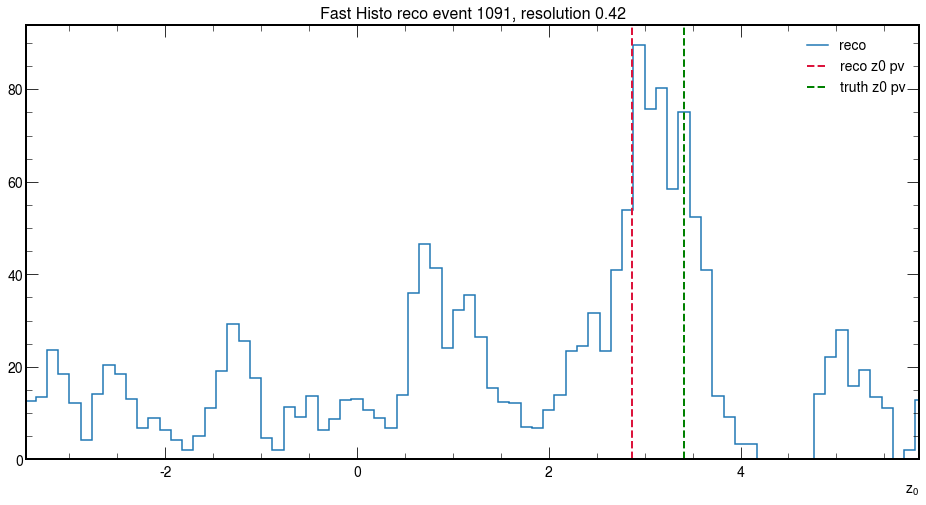

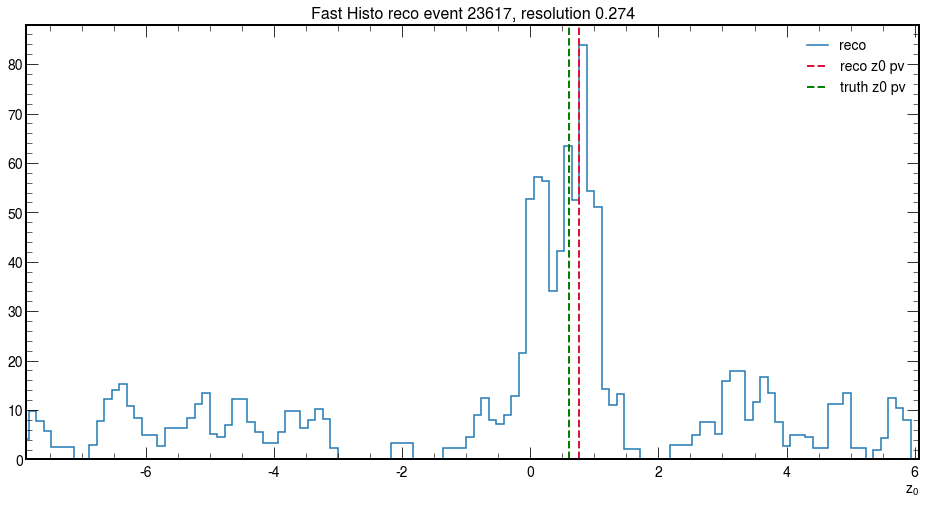

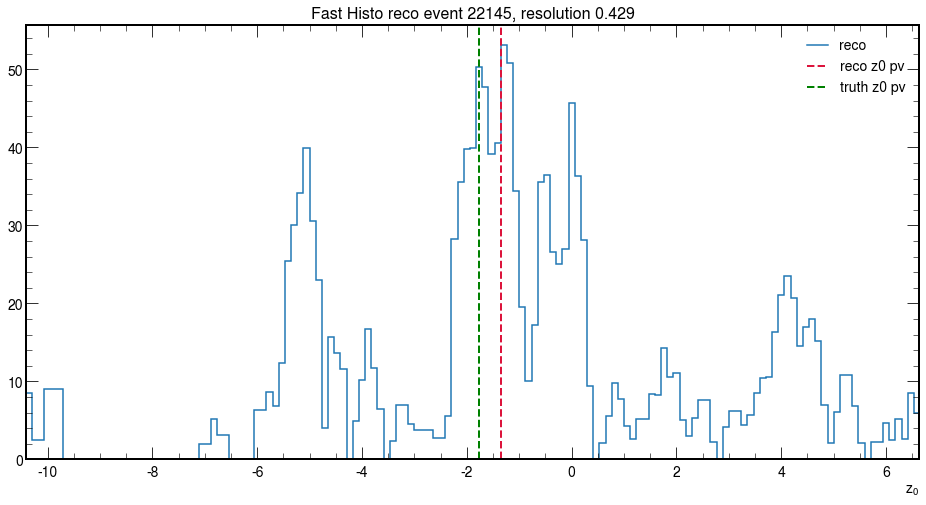

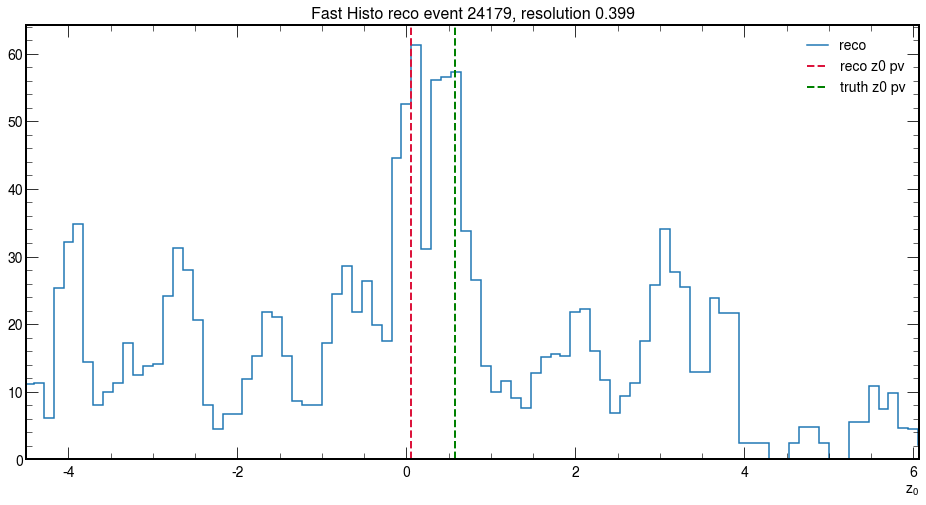

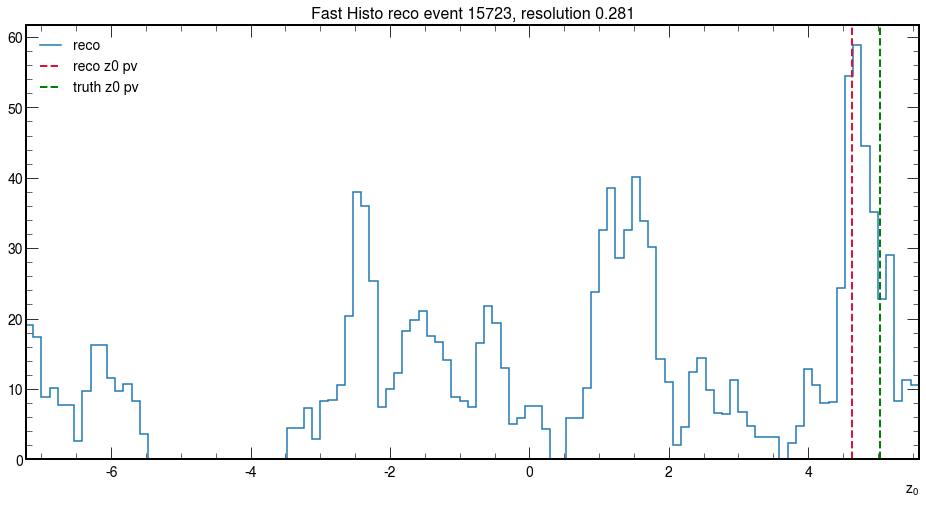

In [237]:
for i in events_to_check_b3:
    plot_fast_histo(PM.trk, mc, res, i, xlim="auto")

# FAST HISTO EVENTS WITH RESOLUTION 0.5 < RES < 1.0

In [190]:
events_to_check_b4 = random.sample(
    list(res_fail.loc[(res_fail["res"] > 0.50) & (res_fail["res"] < 1.0)].index), 20
)

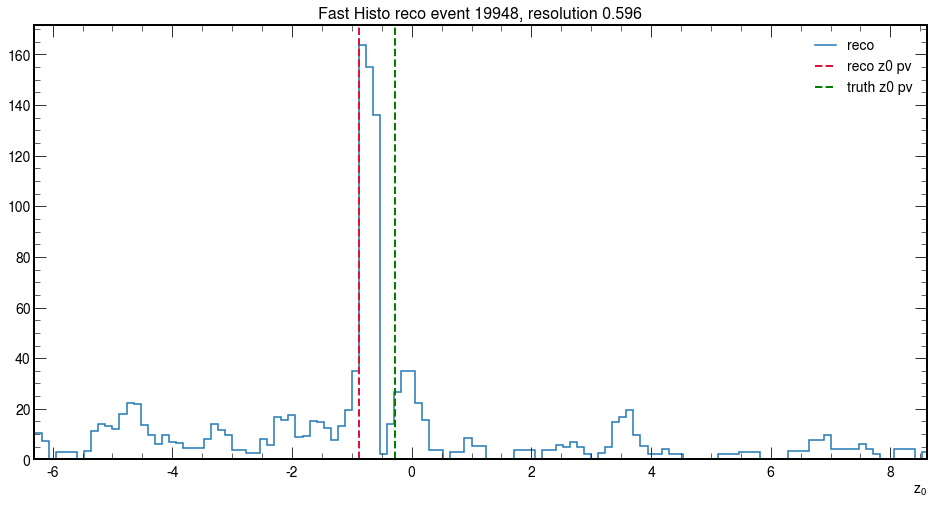

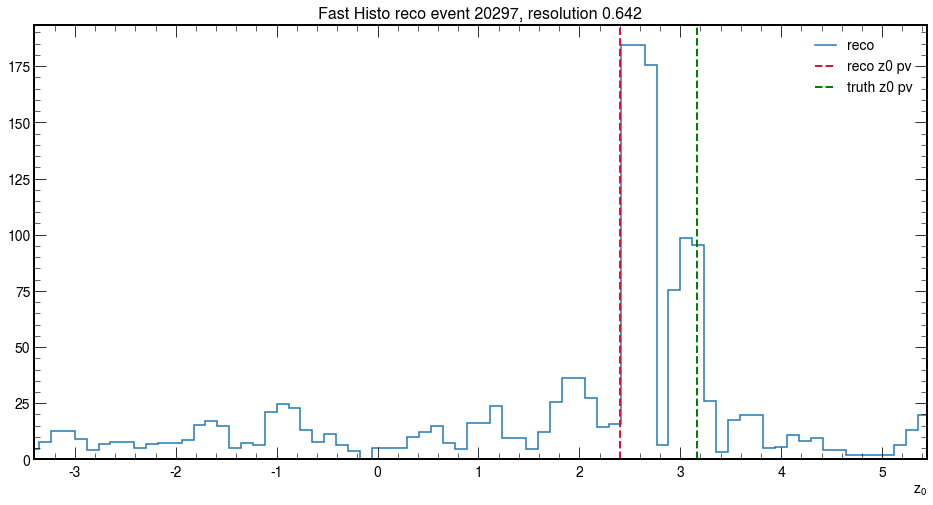

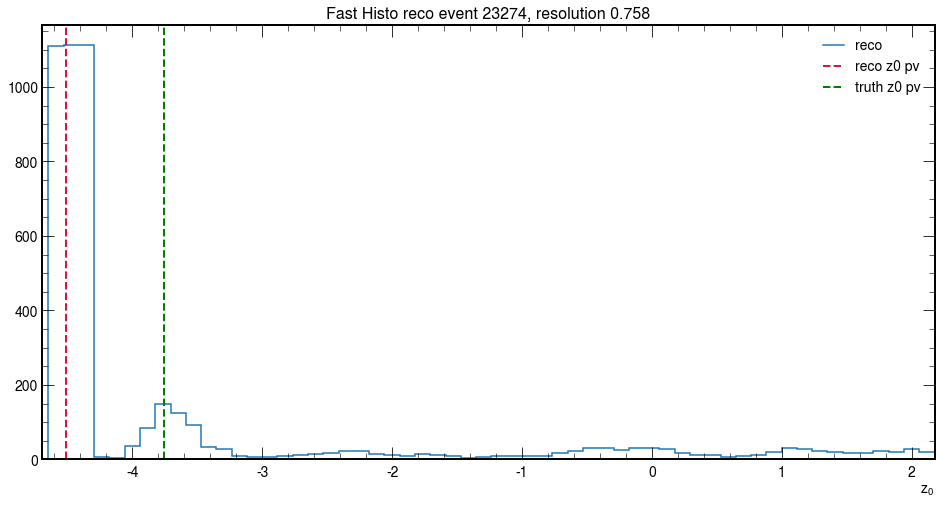

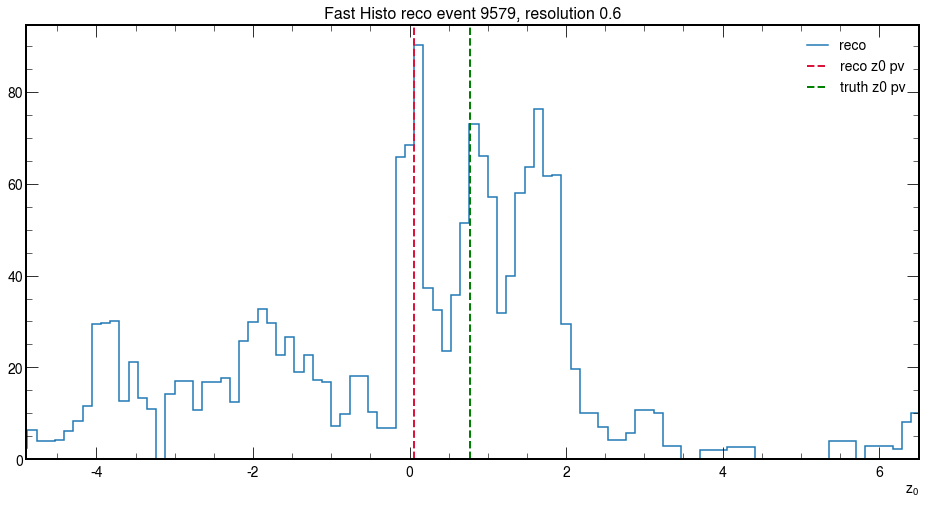

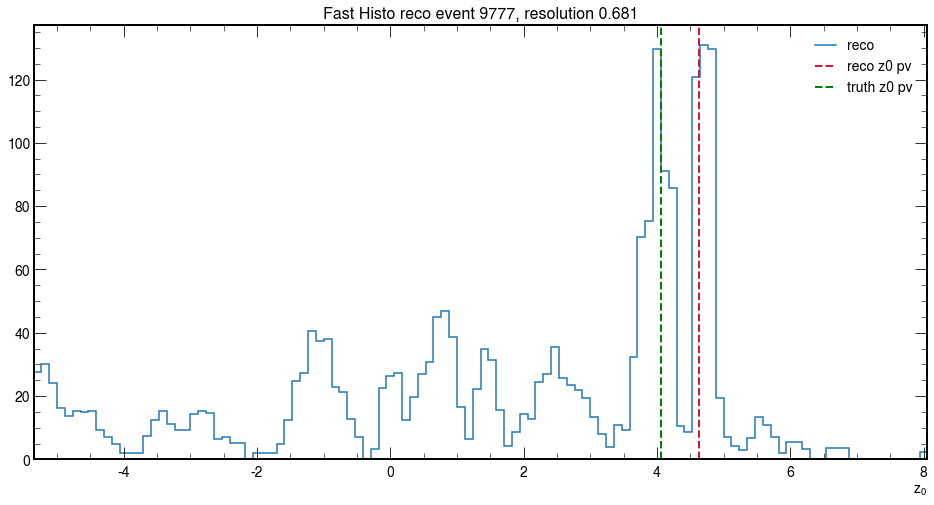

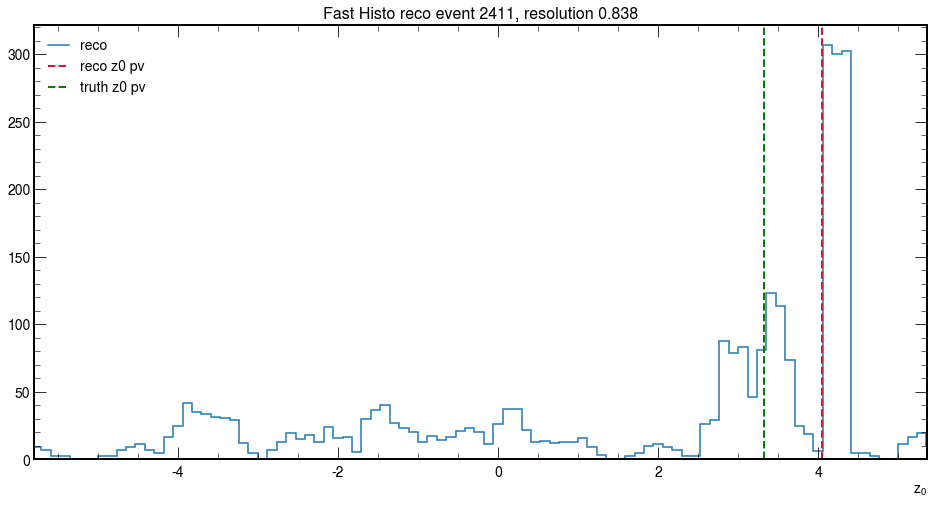

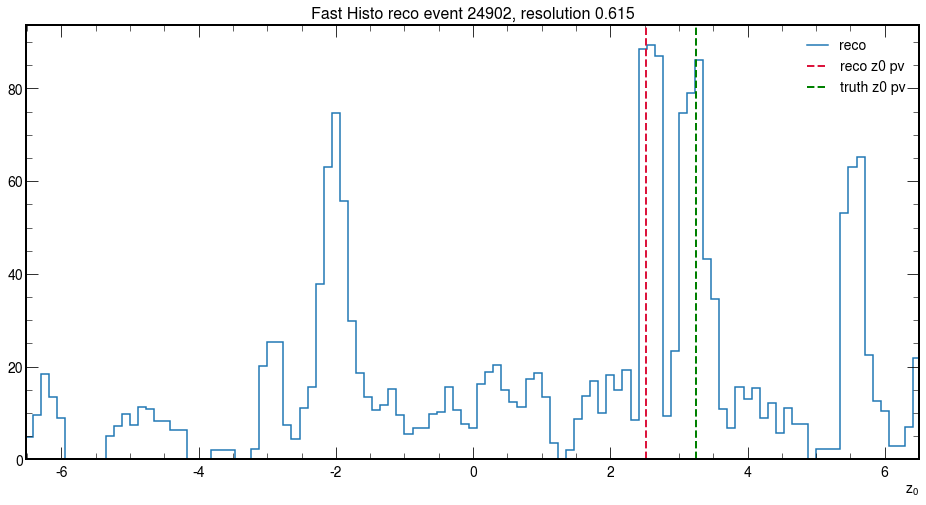

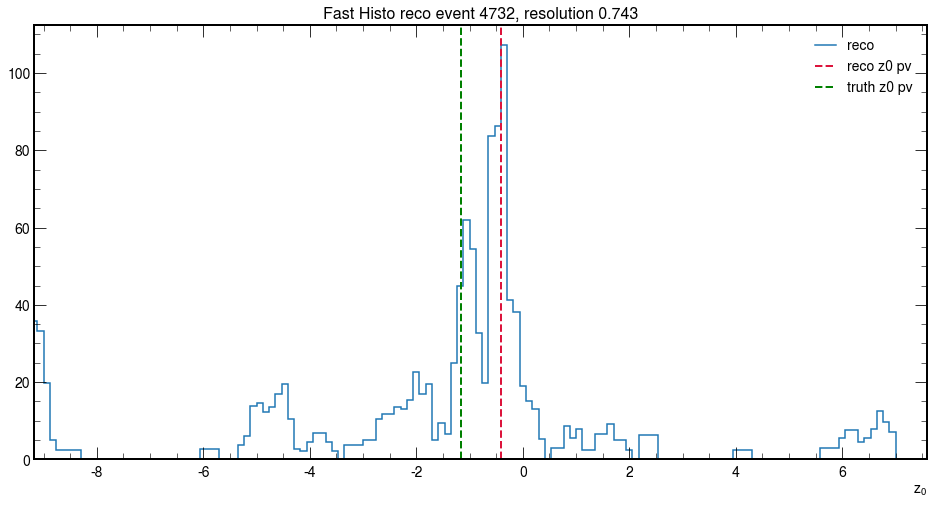

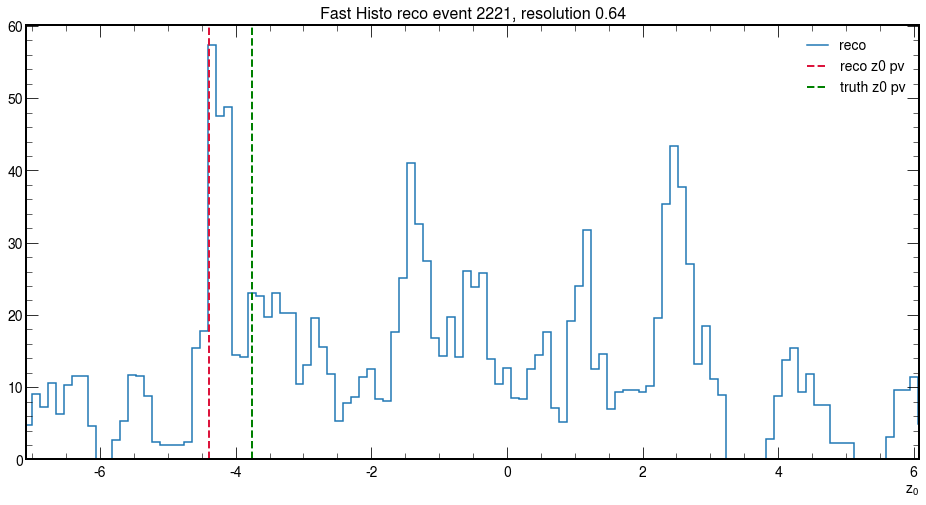

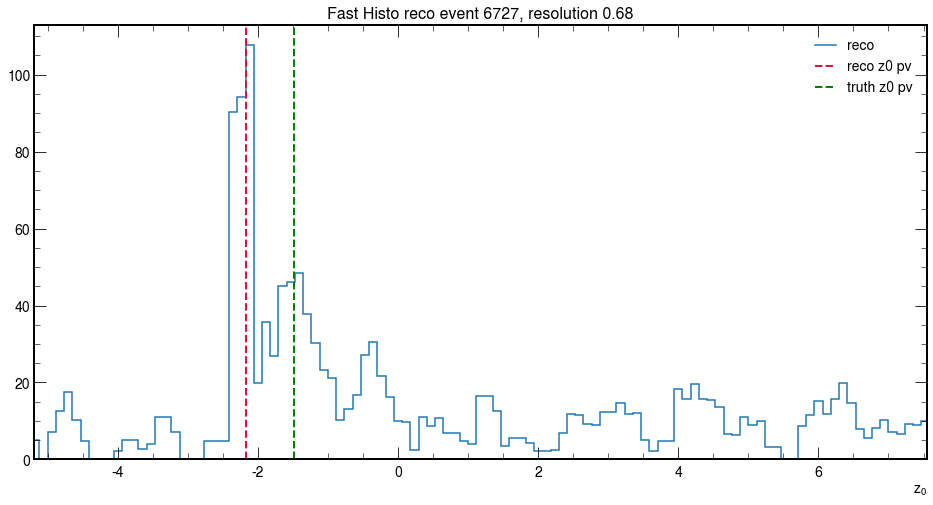

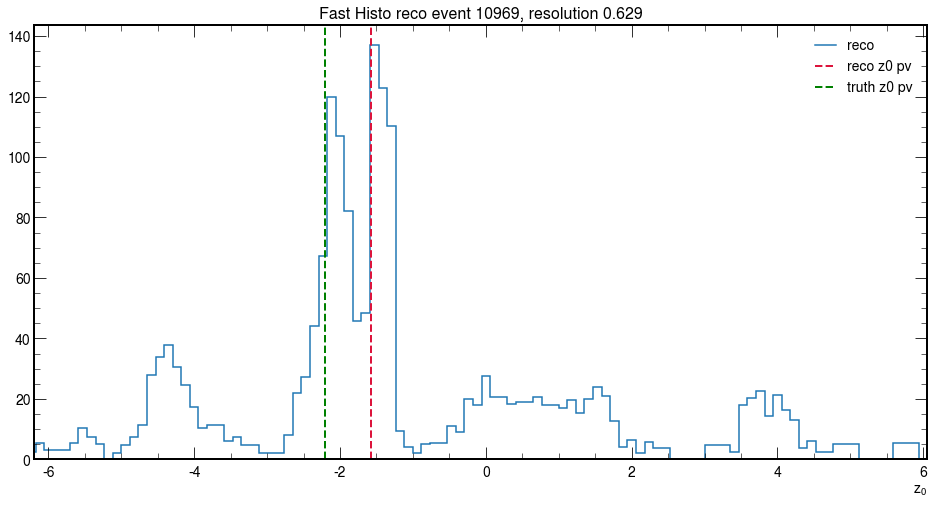

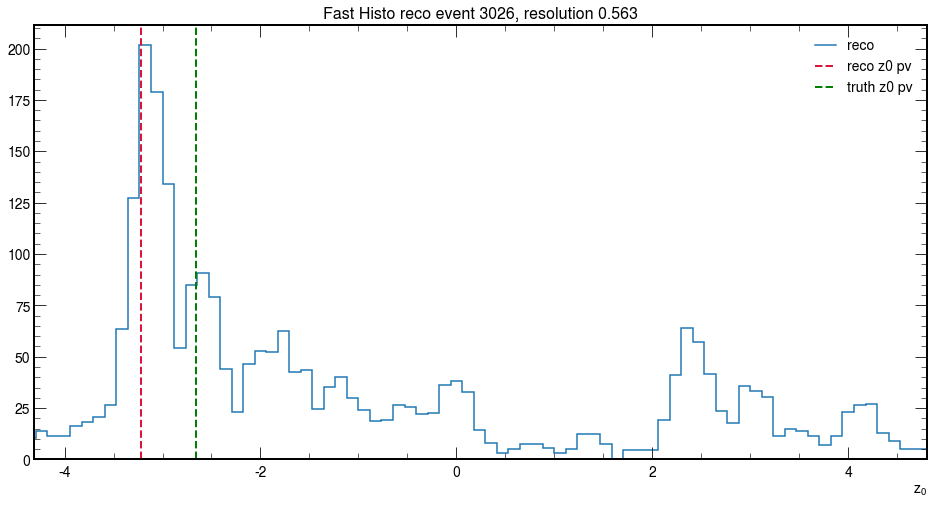

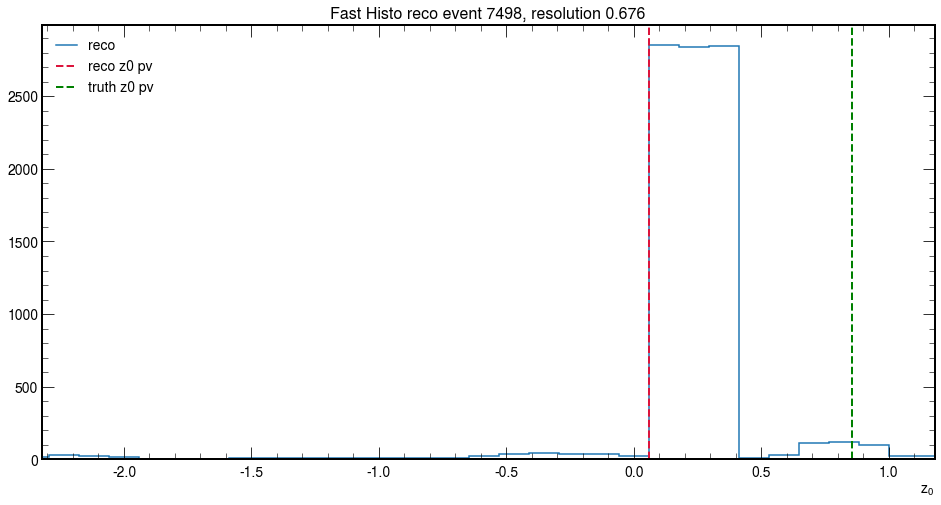

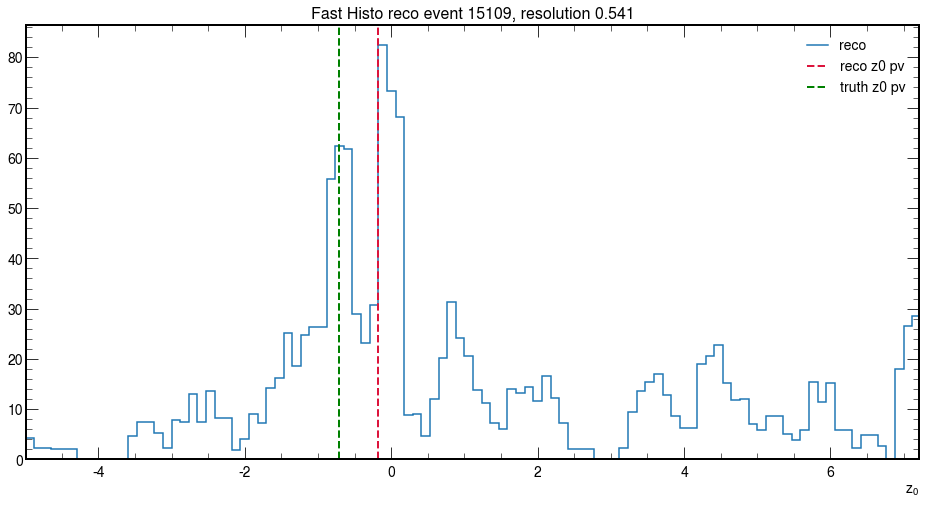

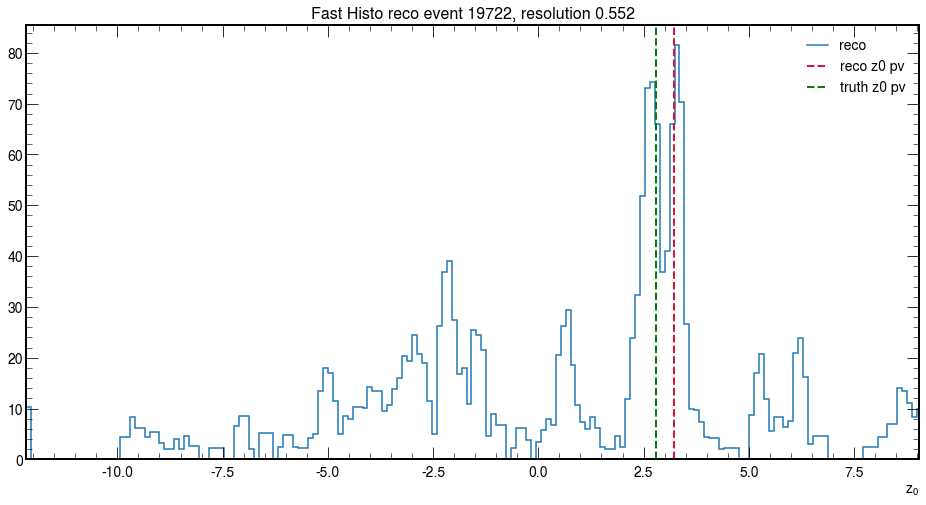

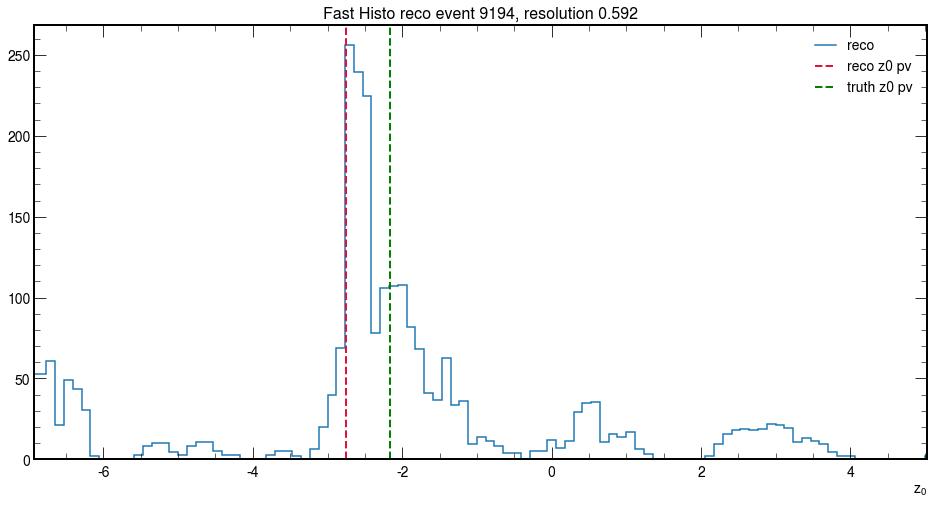

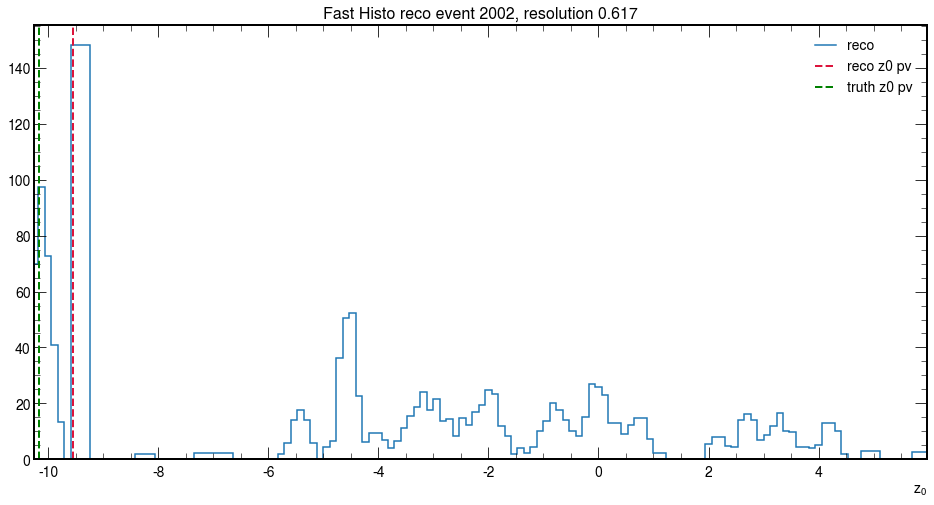

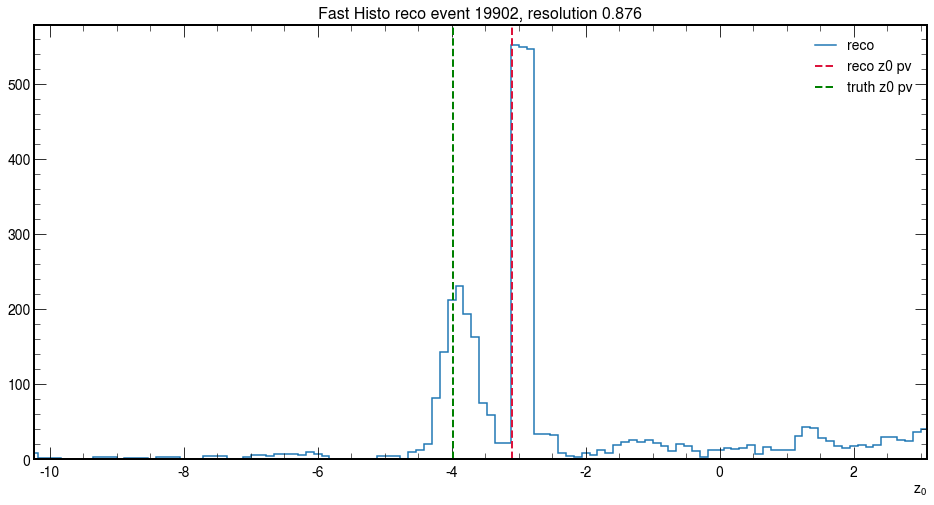

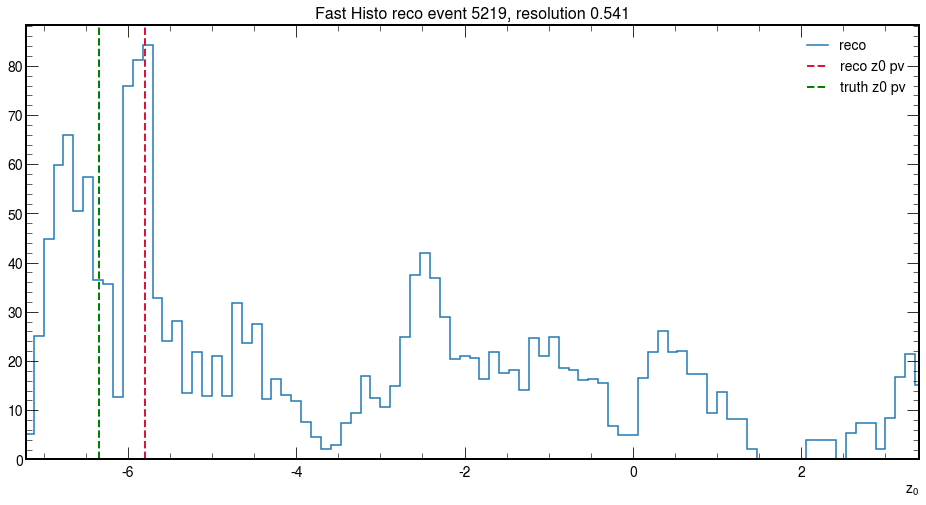

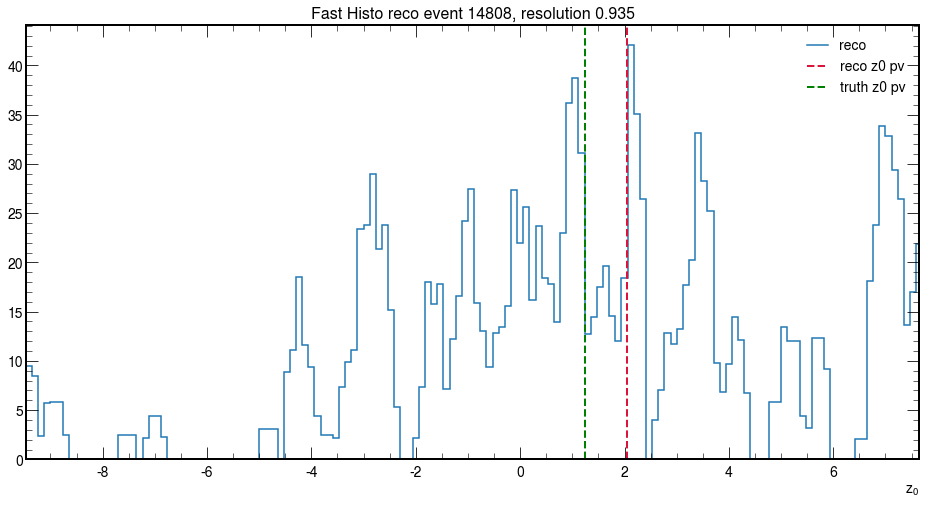

In [239]:
for i in events_to_check_b4:
    plot_fast_histo(PM.trk, mc, res, i, xlim="auto")

# FAST HISTO EVENTS WITH RESOLUTION 1.0 < RES

In [191]:
events_to_check_b5 = random.sample(
    list(res_fail.loc[(res_fail["res"] > 1) & (res_fail["res"] < 30)].index), 20
)

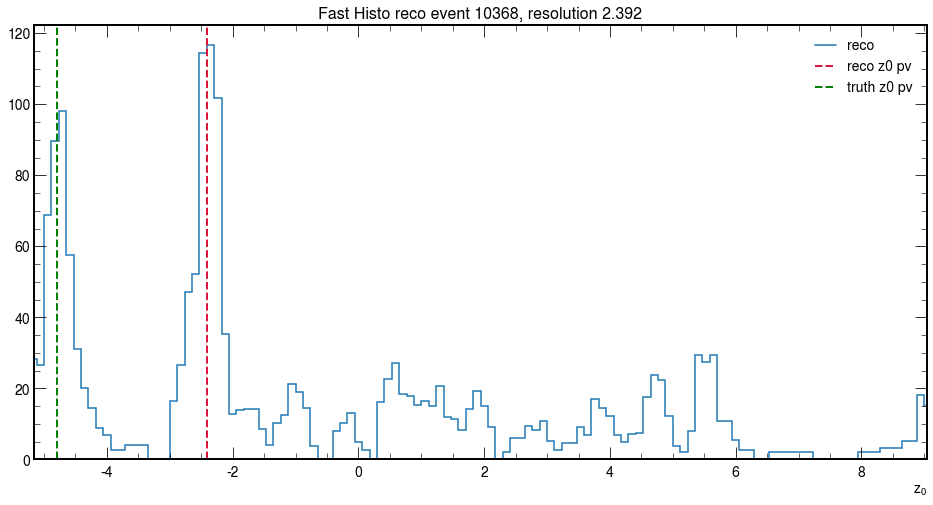

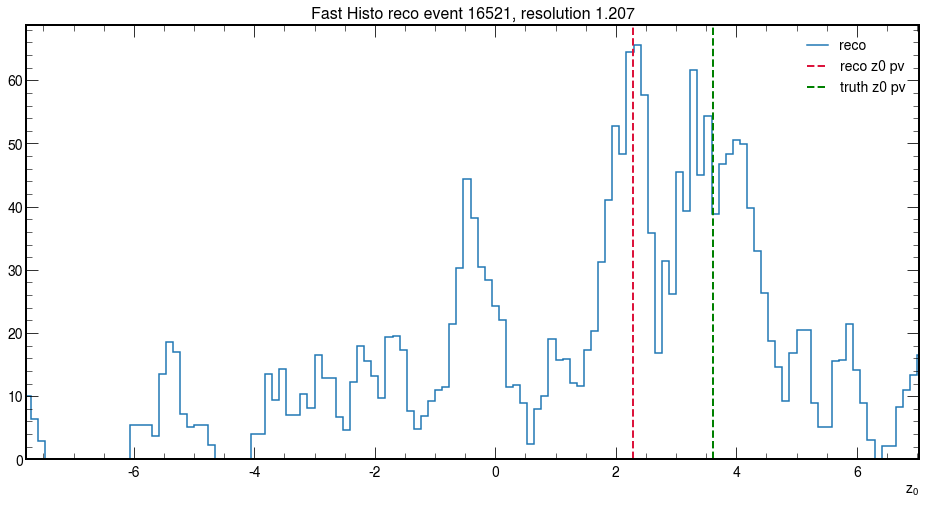

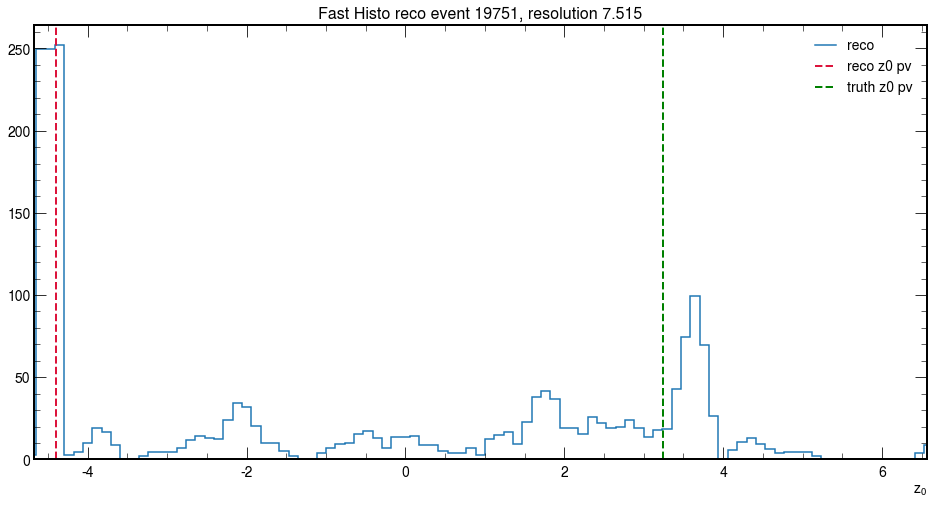

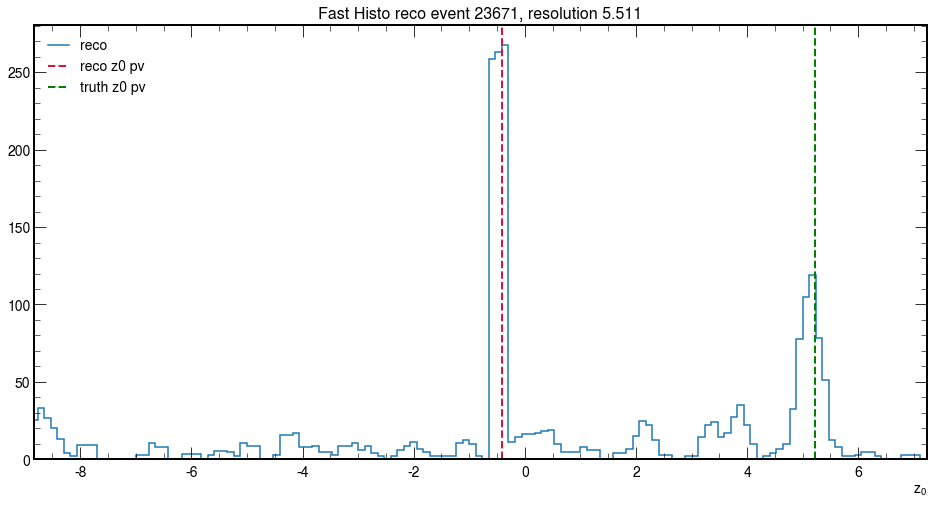

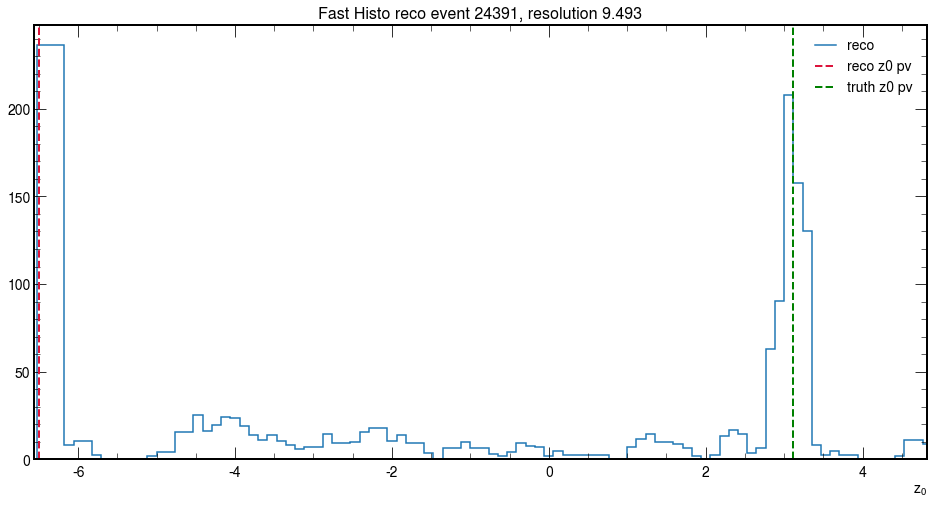

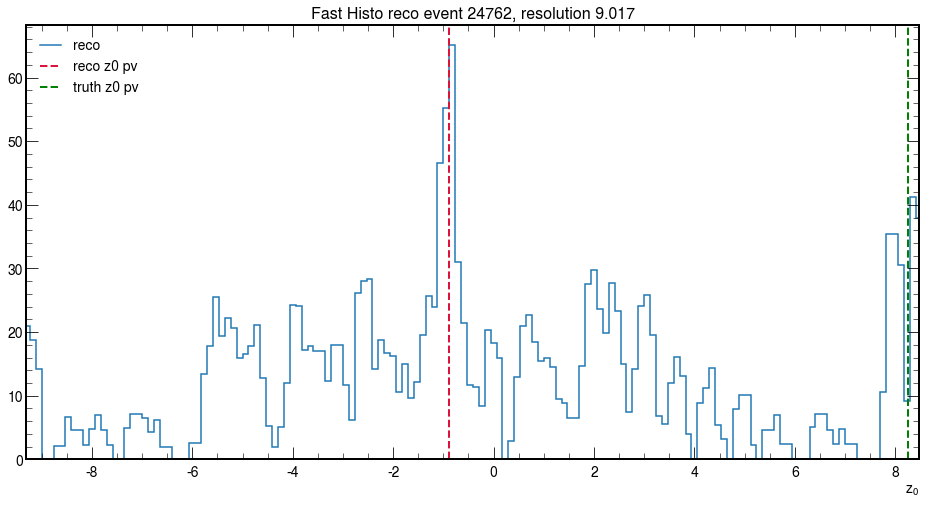

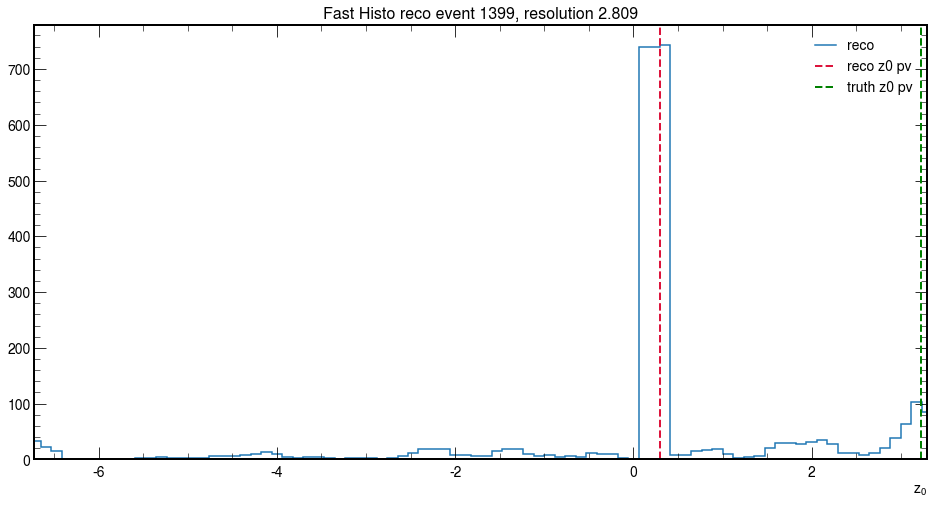

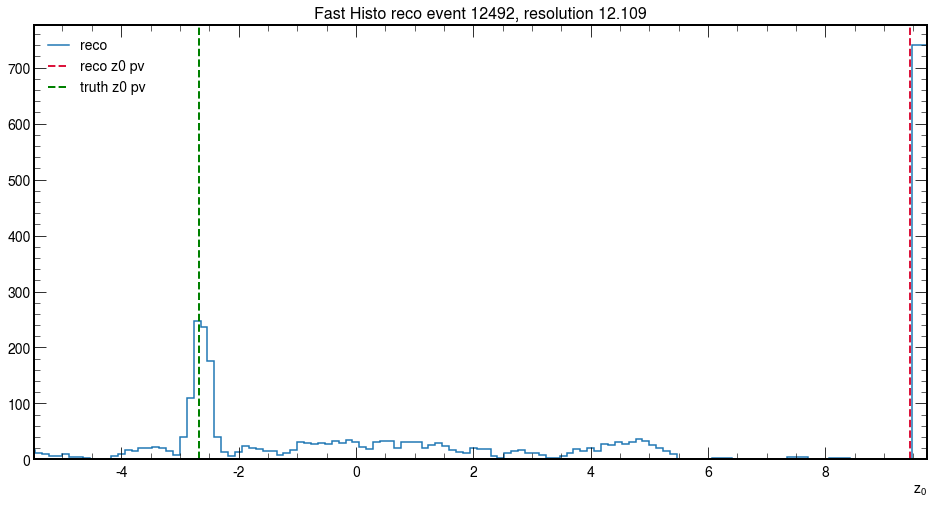

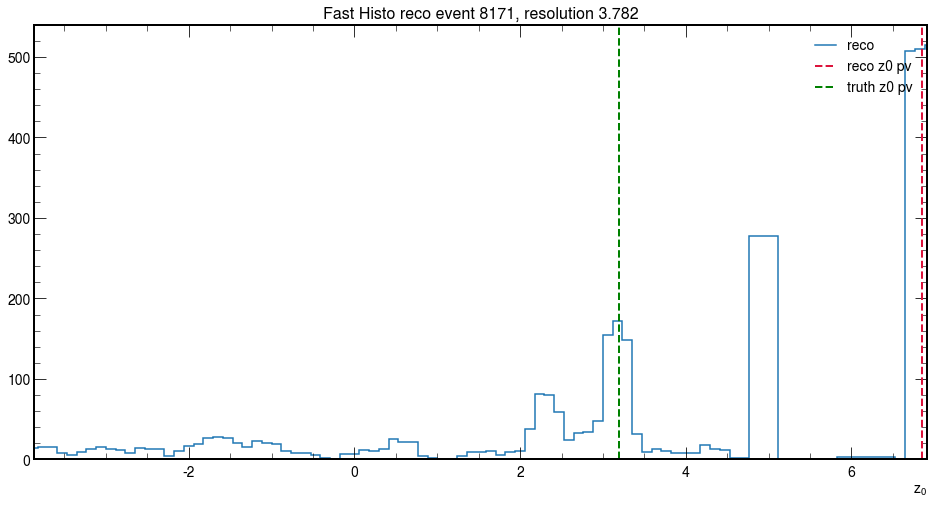

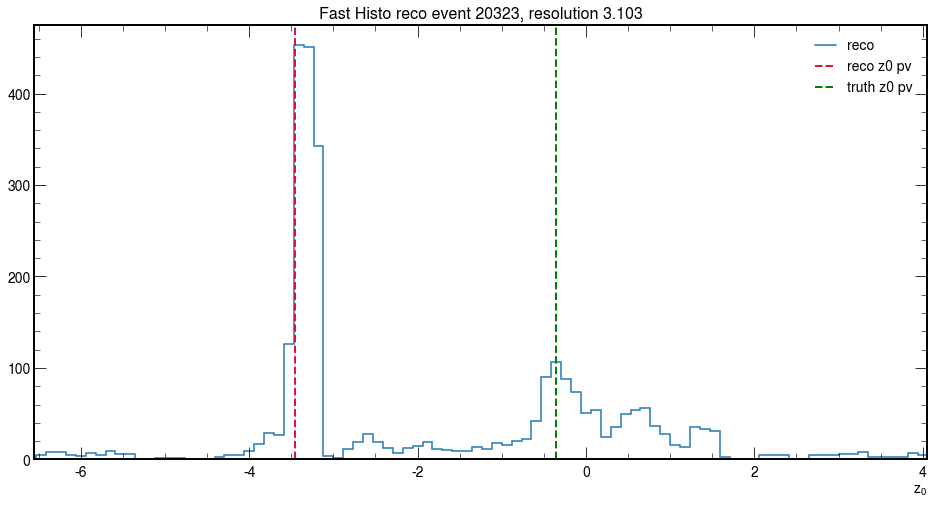

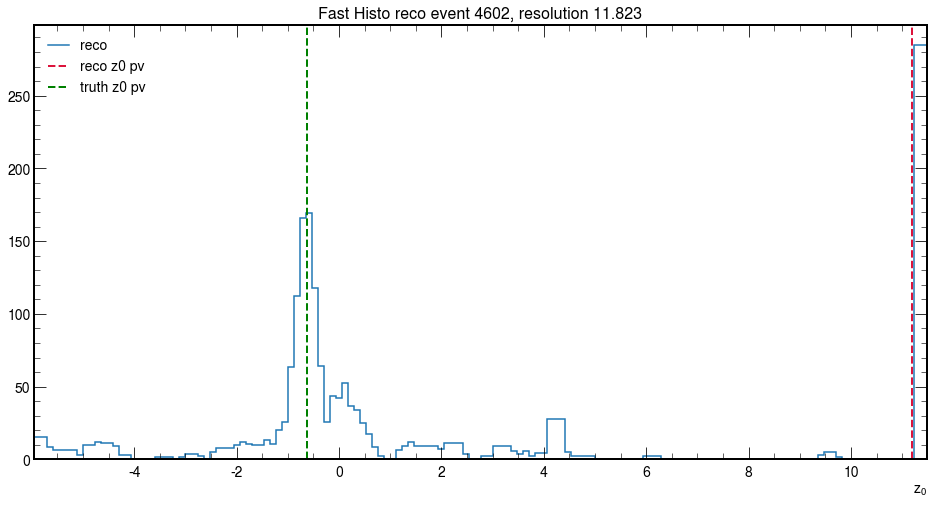

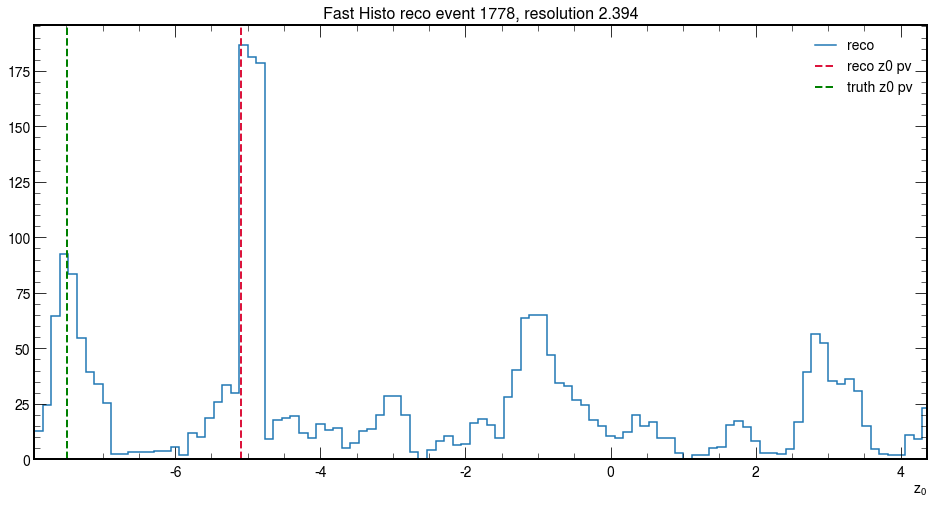

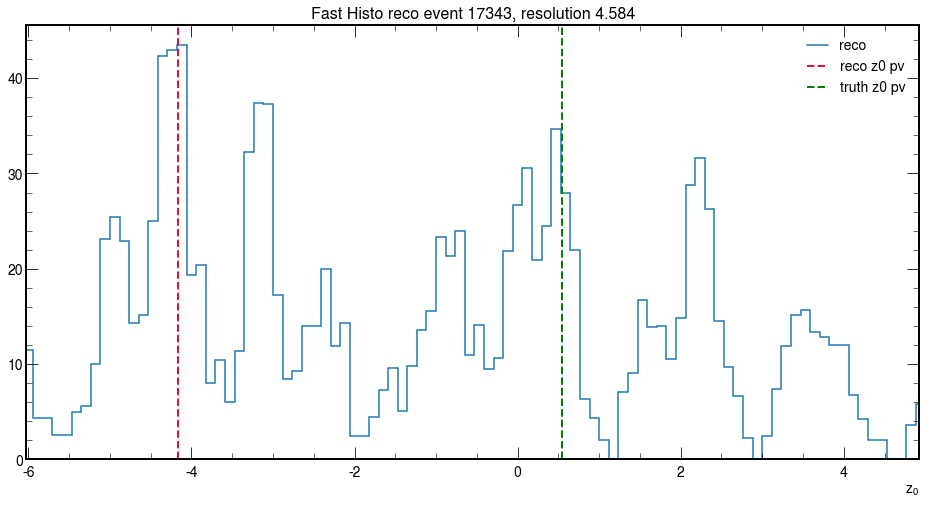

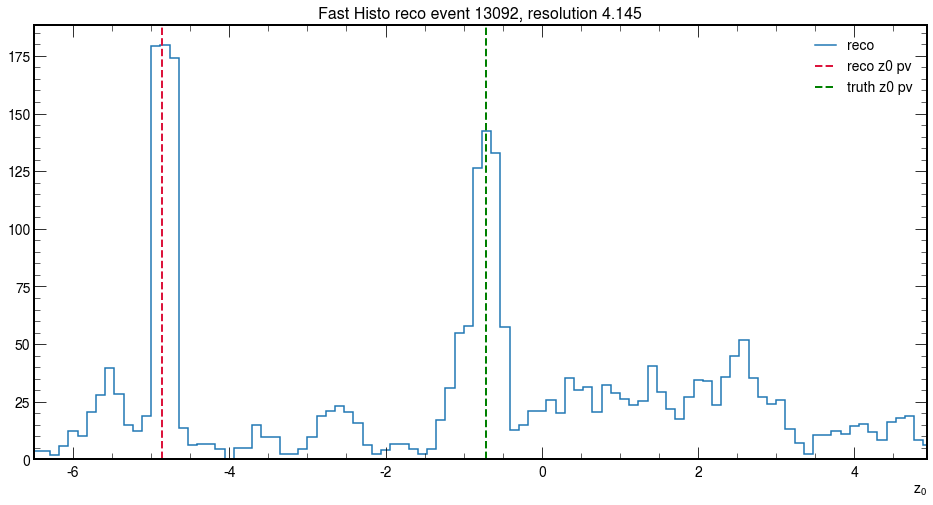

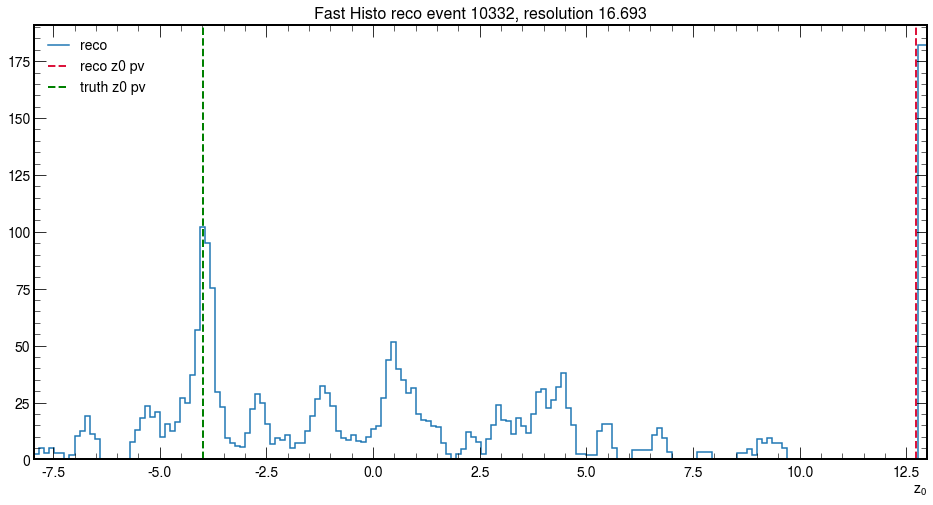

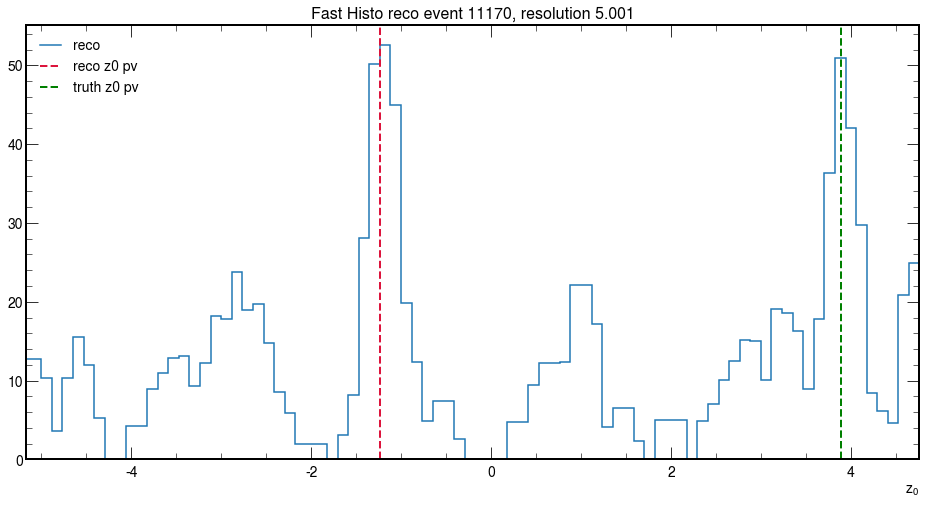

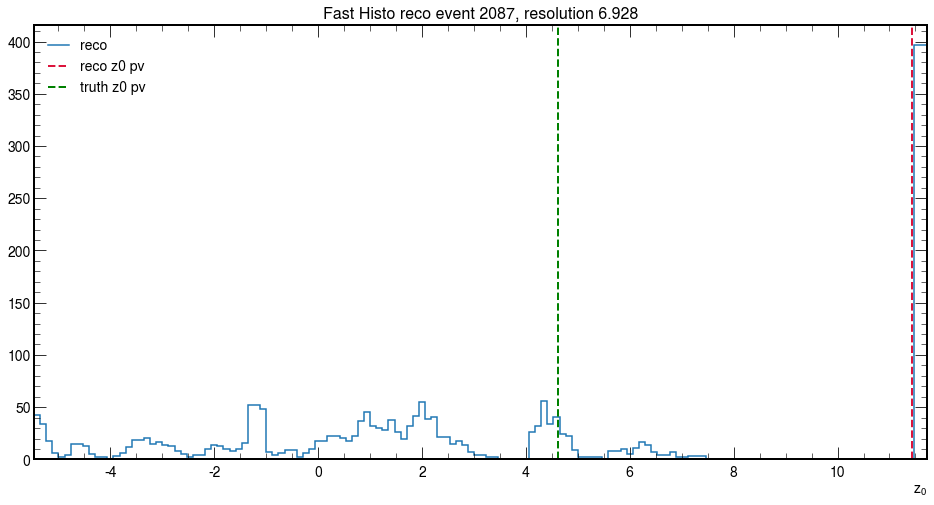

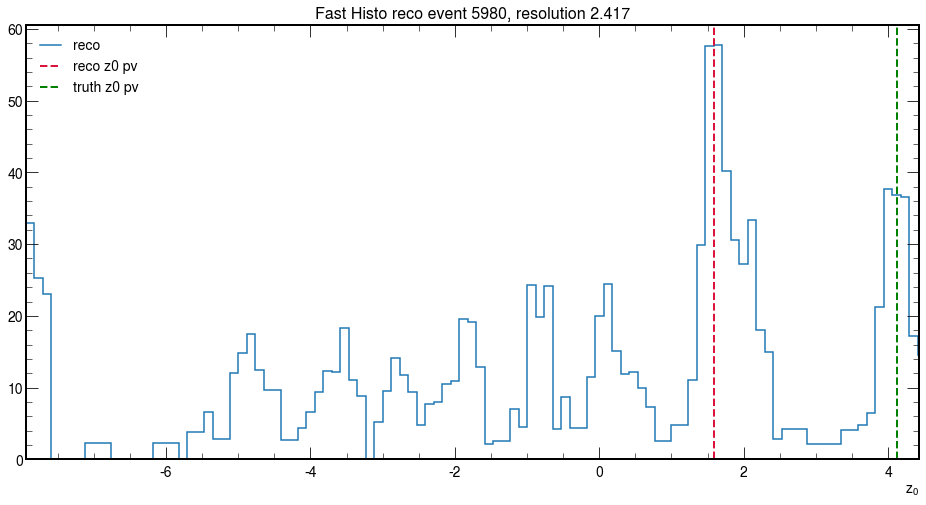

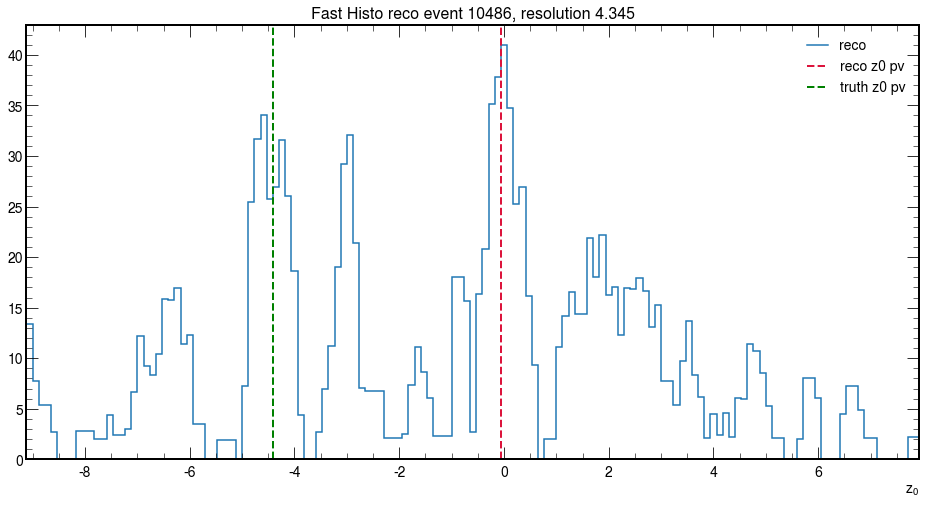

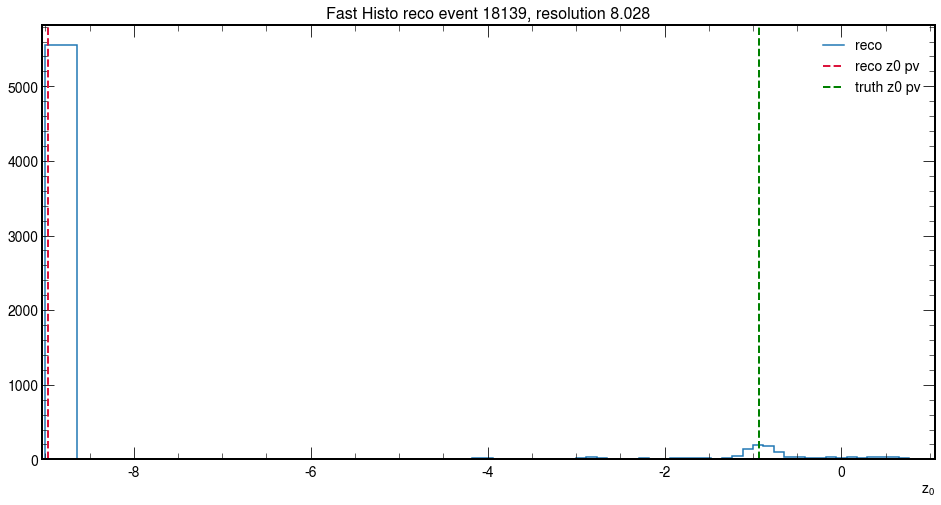

In [238]:
for i in events_to_check_b5:
    plot_fast_histo(PM.trk, mc, res, i, xlim="auto")